In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import scipy.stats as st
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

from sklearn.manifold import TSNE
import plotly.graph_objects as go
import random
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Run in python console
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.corpus import stopwords

import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

username = 'lgburget' # your username
api_key = 'vWYUwXe1jfrskXgIuyVf' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

from gensim.models import CoherenceModel

import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lindadelacombaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# **BOLLYWOOD** vs **HOLLYWOOD**: endgame?

# Data loading

With the loading, we do a simple pre-processing work where we remove punctuation and capitalization from words.

### Movie metadata
This dataset contains the basics informations of differents movies. Here, you have the name of the differents informations and their definition.

| Column name          | Description                                                                                                                                                                                       |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |
| freebase_movie_id| ID of the movie from freebase                                                                                                                                             |
| movie_name | Name of the movie                                                                                                                                                |
| movie_release_date  | Date the movie was released                                                                                                                                      |
| movie_box_office_revenue  | Revenue of the movie box office                                                                                                                           
| movie_runtime  | Run time of the movie                                                                                                                                                 |
| movie_languages | Languages of the movie                                                                                                                                                  |
| movie_countries | Countries where the movie were created                                                                                                                                  |   |   |   |
| movie_genres   | Genre of the movie                                                                                                                                              |




In [2]:
data_folder = './data/'

names = ['wikipedia_movie_id','freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue', 
        'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

movies_data = pd.read_csv(data_folder + 'movie.metadata.tsv', names = names, sep = '\t', )

movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']]= movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda x: str.lower(x))

#character that we delete
#note: we don't delete ',' because we use it to split our columns
spec_char = ['{', '}', '"', ':']

for char in spec_char:
        movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].replace(char, '', regex = True)

#removing the reference where we already have the info we need
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: re.sub('\B\/\w+', '',s))
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: re.sub('\B\/\w+', '',s))
movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']] = movies_data[['movie_name', 'movie_languages', 'movie_countries', 'movie_genres']].applymap(lambda s: s.strip())
movies_data.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventur..."
1,3196793,/m/08yl5d,getting away with murder the jonbenét ramsey m...,2000-02-16,NaN,95.0,english language,united states of america,"mystery, biographical film, drama, crime drama"
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,norwegian language,norway,"crime fiction, drama"
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,english language,united kingdom,"thriller, erotic thriller, psychological thr..."
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,german language,germany,drama


In [3]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  int64  
 1   freebase_movie_id         81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


As we can see above, the dataset is complete except for the categories move_box_office_revenue that are often unavailable and the movie_runtime.

To complete our data, we will use the title.ratings.tsv.gz and title.basics.tsv.gz datasets from IMDb that contain respectivly the ratings  and informations (like the runtime) about them


### IMdb datasets (ratings, runtimes, isAdult)

In [4]:
ratings = pd.read_csv(data_folder + 'title.ratings.tsv.gz', sep='\t', compression='gzip')
titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')

/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/924163708.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv(data_folder + 'title.basics.tsv.gz', sep='\t', compression='gzip')


In [5]:
#merging IMdb dataset with title, isAdult and runtimeMinutes with dataset with averageRating on movie ID (tconst)
rates = titles.merge(ratings, how='left', on='tconst')[['averageRating', 'numVotes', 'originalTitle', 'isAdult', 'runtimeMinutes']]

#putting all titles to lower case to match the CMU dataset movie names and dropping column with upper cases
rates['movie_name'] = [ele.lower() for ele in rates['originalTitle'].astype(str)]
rates=rates.drop(columns='originalTitle')

#dropping all rows that have a movie name appearing multiple times so the merging on movie name with the CMU dataset is precise
rates = rates.drop_duplicates('movie_name', keep=False)

#converting runtimeMinutes to float and changing '\\N' to NaN to match the format in CMU dataset
rates['runtimeMinutes']=list(map(lambda x: float(x) if x!='\\N' else None , rates['runtimeMinutes']))

In [6]:
#merging CMU dataset with the IMdb dataset
movies_data_merged = movies_data.merge(rates, how = 'left', on='movie_name')

# Completing the NaN values in movie_runtime of the CMU dataset with the available ones of the IMdb dataset.
# We trust more the CMU dataset than the IMdb one so we give priority to the runtime values of the CMU dataset
# to the IMdb ones, hence we use the IMdb only if the value is missing in the CMU.
movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'movie_runtime']=movies_data_merged.loc[movies_data_merged['movie_runtime'].isna(), 'runtimeMinutes']

# Finally, we drop the column with the IMdb runtimes.
movies_data_merged=movies_data_merged.drop(columns='runtimeMinutes')
movies_data_merged.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventur...",NaN,NaN,NaN
1,3196793,/m/08yl5d,getting away with murder the jonbenét ramsey m...,2000-02-16,NaN,95.0,english language,united states of america,"mystery, biographical film, drama, crime drama",NaN,NaN,NaN
2,28463795,/m/0crgdbh,brun bitter,1988,NaN,83.0,norwegian language,norway,"crime fiction, drama",5.7,40.0,0
3,9363483,/m/0285_cd,white of the eye,1987,NaN,110.0,english language,united kingdom,"thriller, erotic thriller, psychological thr...",6.1,2635.0,0
4,261236,/m/01mrr1,a woman in flames,1983,NaN,106.0,german language,germany,drama,NaN,NaN,NaN


For further analysis, as we want to analyze indian and american movies, we will select the films that are only from both countries and separate them into two dataframes.

In [7]:
movies_indian = movies_data_merged[movies_data_merged['movie_countries'] == 'india'].reset_index()
movies_american = movies_data_merged[movies_data_merged['movie_countries'] == 'united states of america'].reset_index()

In [8]:
movies_american.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult
0,0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventur...",NaN,NaN,NaN
1,1,3196793,/m/08yl5d,getting away with murder the jonbenét ramsey m...,2000-02-16,NaN,95.0,english language,united states of america,"mystery, biographical film, drama, crime drama",NaN,NaN,NaN
2,5,13696889,/m/03cfc81,the gangsters,1913-05-29,NaN,35.0,"silent film, english language",united states of america,"short film, silent film, indie, black-and-w...",NaN,NaN,NaN
3,7,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,english language,united states of america,"musical, comedy, black-and-white",NaN,NaN,NaN
4,10,175026,/m/017n1p,sarah and son,1930,NaN,86.0,english language,united states of america,"drama, black-and-white",5.4,272.0,0


In [9]:
movies_indian.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult
0,27,20604092,/m/0523t_1,anbu thozhi,2007-08-17,NaN,NaN,tamil language,india,romance film,NaN,NaN,0
1,30,11448183,/m/02rc_h4,bindiya chamkegi,1984-01-20,NaN,NaN,hindi language,india,"family film, comedy",NaN,NaN,NaN
2,31,9633533,/m/02pml15,vandanam,1989,NaN,168.0,malayalam language,india,action,7.9,1198.0,0
3,35,29528534,/m/04j0lfk,anokha rishta,1986,NaN,180.0,hindi language,india,"world cinema, musical, drama, romantic dram...",7.3,57.0,0
4,37,29772142,/m/0fq260_,karayilekku oru kadal dooram,2010-12-31,NaN,110.0,malayalam language,india,drama,6.6,15.0,0


In [10]:
print('There are %d indian films and %d american films in the dataset.' % (len(movies_indian), len(movies_american)))

There are 8240 indian films and 30300 american films in the dataset.


### Film summaries dataset

In [11]:
#Read file
summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\r', names = ['summaries'])
#Split 
summaries = summaries['summaries'].str.split("\t", expand = True)
#Rename the columns
summaries = summaries.rename(columns= {0:'wikipedia_movie_id',1: 'summaries'})
#Lowercase
summaries['summaries'] = summaries['summaries'].str.lower()
#Wiki movie id as integer
summaries['wikipedia_movie_id'] = summaries['wikipedia_movie_id'].astype(int)
summaries.head()

,wikipedia_movie_id,summaries
0,23890098,"shlykov, a hard-working taxi driver and lyosha..."
1,31186339,the nation of panem consists of a wealthy capi...
2,20663735,poovalli induchoodan is sentenced for six yea...
3,2231378,"the lemon drop kid , a new york city swindler,..."
4,595909,seventh-day adventist church pastor michael ch...


### Characters metadata


| Column name          | Description                                                                                                                                                                                       |
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| wikipedia_movie_id | ID of the movie from wikipedia                                                                                                                                                 |
| freebase_movie_id| ID of the movie from freebase                                                                                                                                            |
| movie_release_date | Date the movie was released                                                                                                                                                |
| character_name  | Name of the character played                                                                                                                        
| actor_dob  | Date of birth of the actor                                                                                                                                                 |
| actor_gender | Actor gender (F or M)                                                                                                                                                  |
| actor_height | Actor height (in [m])                                                                                                                                  |   |   |   |
| actor_ethnicity   | Actor ethnicity (in freebase ID)                                                                                                                                             |
| actor_name | Actor name                                                                                                                                                 |
| actor_age_at_movie_release | Age of the actor at the movie release                                                                                                                                                 |
| char_act_id | Actor ID                                                                                                                                                 |
| freebase_character_id | ID of the character from freebase                                                                                                                                                  |
| freebase_actor_id | ID of the actor from freebase                                                                                                                                                 |

In [12]:
#Prepare names for the colums
names = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date', 'character_name', 'actor_dob', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age_at_movie_release', 'char_act_id', 'freebase_character_id', 'freebase_actor_id']
#Read file
characters_data = pd.read_csv(data_folder + 'character.metadata.tsv', names = names, sep = '\t')
#Lower case 
characters_data[['character_name', 'actor_name']] = characters_data[['character_name', 'actor_name']].applymap(lambda x: x if type(x)!=str else x.lower())
characters_data.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,char_act_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,akooshay,1958-08-26,F,1.620,NaN,wanda de jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,lieutenant melanie ballard,1974-08-15,F,1.780,/m/044038p,natasha henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,desolation williams,1969-06-15,M,1.727,/m/0x67,ice cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,sgt jericho butler,1967-09-12,M,1.750,NaN,jason statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,bashira kincaid,1977-09-25,F,1.650,NaN,clea duvall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
characters_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   wikipedia_movie_id          450669 non-null  int64  
 1   freebase_movie_id           450669 non-null  object 
 2   movie_release_date          440674 non-null  object 
 3   character_name              192794 non-null  object 
 4   actor_dob                   344524 non-null  object 
 5   actor_gender                405060 non-null  object 
 6   actor_height                154824 non-null  float64
 7   actor_ethnicity             106058 non-null  object 
 8   actor_name                  449441 non-null  object 
 9   actor_age_at_movie_release  292556 non-null  float64
 10  char_act_id                 450669 non-null  object 
 11  freebase_character_id       192804 non-null  object 
 12  freebase_actor_id           449854 non-null  object 
dtypes: float64(2),

### Including ethnicities

Using the automatic query system from wikidata, we were able to retrieve the ethnicity of the actors based on the freebase ID in the actor_ethnicity column. 

We then map the matching id to the string-representation of the ethnicity.

In [14]:
#Read file
actor_ethnicities = pd.read_csv('data/ethnicities.csv')[['freebaseID', 'name']]
actor_ethnicities = dict(zip(actor_ethnicities.freebaseID, actor_ethnicities.name))
#Map the ethnicity id to the ethnicity name
characters_data['actor_ethnicity'] = characters_data['actor_ethnicity'].map(actor_ethnicities)

# Exploratory Data Analysis of American and Indian movies

### Numbers of Indian vs American movies per year

In [15]:
movies_years_indian = movies_indian.copy()

#slice the movie release date column to only have the years, and transform them as integer again
movies_years_indian['movie_release_date'] = movies_indian['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for indian movies
n_movie_per_year_indian = movies_years_indian.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_indian = pd.DataFrame(n_movie_per_year_indian).reset_index()

#sort the values
n_movie_per_year_indian['movie_release_date'] = n_movie_per_year_indian['movie_release_date'].sort_values()

n_movie_per_year_indian

,movie_release_date,count
0,1912.0,1
1,1913.0,1
2,1919.0,1
3,1921.0,1
4,1928.0,4
...,...,...
84,2010.0,256
85,2011.0,165
86,2012.0,274
87,2013.0,24


In [16]:
movies_years_american = movies_american.copy()

#slice the movie release date column to only have the years, and transform them as integer again
movies_years_american['movie_release_date'] = movies_years_american['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

#count the numbers of movies per year there are for american movies
n_movie_per_year_american = movies_years_american.groupby('movie_release_date')['movie_name'].agg(['count'])

#change the movie release date as a column
n_movie_per_year_american = pd.DataFrame(n_movie_per_year_american).reset_index()

#sort the values
n_movie_per_year_american['movie_release_date'] = n_movie_per_year_american['movie_release_date'].sort_values()

n_movie_per_year_american

,movie_release_date,count
0,1890.0,1
1,1891.0,1
2,1893.0,1
3,1894.0,9
4,1895.0,1
...,...,...
120,2012.0,331
121,2013.0,80
122,2014.0,4
123,2015.0,2


Let us slice the data to have the same time frame: from 1912 to 2014 for both Indian and American movies.

In [17]:
#Slice the data to have same time frame for both Indian and American movies data sets
n_movie_per_year_american = n_movie_per_year_american.query('movie_release_date <= 2014 & movie_release_date >= 1912')

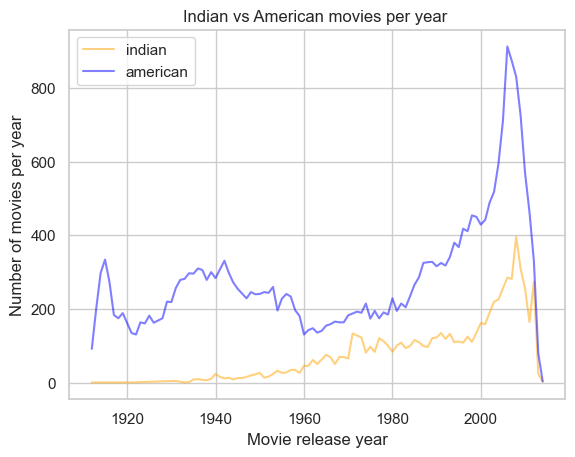

In [18]:
#Plot both Indian and American numbers of movies per year
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian', color = 'orange', alpha = .5)
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american', color = 'blue', alpha = .5)
plt.title('Indian vs American movies per year ')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.show()

We can observe a peak starting to grow from the 2000 years for both Hollywood and Bollywood movies.

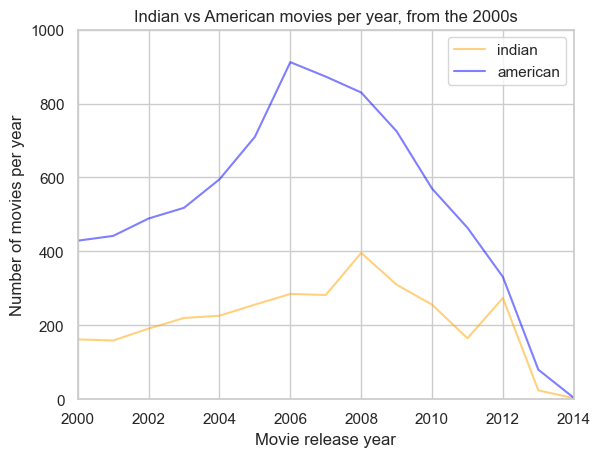

In [19]:
#Zoom in during the peak of Indian and American released movie years
sns.lineplot(data= n_movie_per_year_indian, x='movie_release_date', y = 'count', label='indian', color = 'orange', alpha = .5)
sns.lineplot(data= n_movie_per_year_american, x='movie_release_date', y = 'count', label='american',color = 'blue', alpha = .5)
plt.title('Indian vs American movies per year, from the 2000s')
plt.xlabel('Movie release year')
plt.ylabel('Number of movies per year')
plt.axis([2000, 2014, 0, 1000])
plt.show()

The peak of released movies are at 2006 for Hollywood and 2008 Bollywood respectively.

At 2014 it goes back to nearly 0 films released, so the CMU movie data base could have lacked data from this period on, as according to https://stephenfollows.com/how-many-films-are-released-each-year/, movies should keep being produced and growing from the 2008 years for the USA industry.

We decided for consistency to begin the data set in the 1980 to 2010 time frame for both Hollywood and Bollywood movies.

It was convenient to cut to 2010 instead of 2006 to create equal bins with the same number of points, in a 10 year period for our subsequent analysis.


In [20]:
# Transform the movie release date column to only have the years, and transform them as integer again
movies_indian['movie_release_date'] = movies_indian['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')
movies_american['movie_release_date'] = movies_american['movie_release_date'].dropna().astype('str').apply(lambda s: s[0:4]).astype('int')

# Cut the data from 1980 to 2010 to have the same time frame for both Indian and American movies data sets
cut_movies_american = movies_american.query('movie_release_date <= 2010 & movie_release_date >= 1980')
cut_movies_indian = movies_indian.query('movie_release_date <= 2010 & movie_release_date >= 1980')

## Movie runtime

In [21]:
print('%.3f percent of indian movies have a runtime and %.3f percent of american movies have a runtime' %
(100-np.sum(cut_movies_indian['movie_runtime'].isna())/cut_movies_indian.shape[0]*100, 100-np.sum(cut_movies_american['movie_runtime'].isna())/cut_movies_american.shape[0]*100))

print('Average runtime of indian movies : %.3f \tAverage runtime of american movies : %.3f' %
(cut_movies_indian['movie_runtime'].mean(), cut_movies_american['movie_runtime'].mean()))


66.921 percent of indian movies have a runtime and 96.166 percent of american movies have a runtime
Average runtime of indian movies : 141.049 	Average runtime of american movies : 176.049


### Distribution of movie runtimes

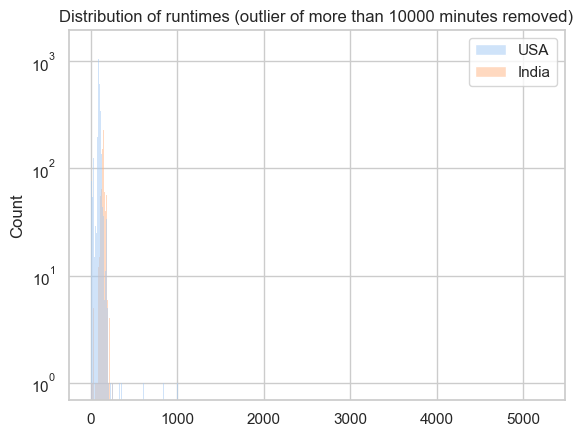

In [22]:
data_runtime = pd.DataFrame({'USA': cut_movies_american.query('movie_runtime < 10000')['movie_runtime'], 'India': cut_movies_indian.query('movie_runtime < 10000')['movie_runtime']})
sns.histplot(data = data_runtime, palette = 'pastel')
plt.yscale('log')
plt.title(f'Distribution of runtimes (outlier of more than 10000 minutes removed)')
plt.show()

From this plot we can see that we have a few outliers in both datasets. 

Let us look at the plot again without the films that are longer than 1000 minutes (16 hours).

In [23]:
print('Number of films longer than 16 hours:', len(cut_movies_indian.query('movie_runtime > 1000')) + len(cut_movies_american.query('movie_runtime > 1000')))

Number of films longer than 16 hours: 4


Let us look at the movie runtime without the outliers (only 4 films are longer than 16 hours)

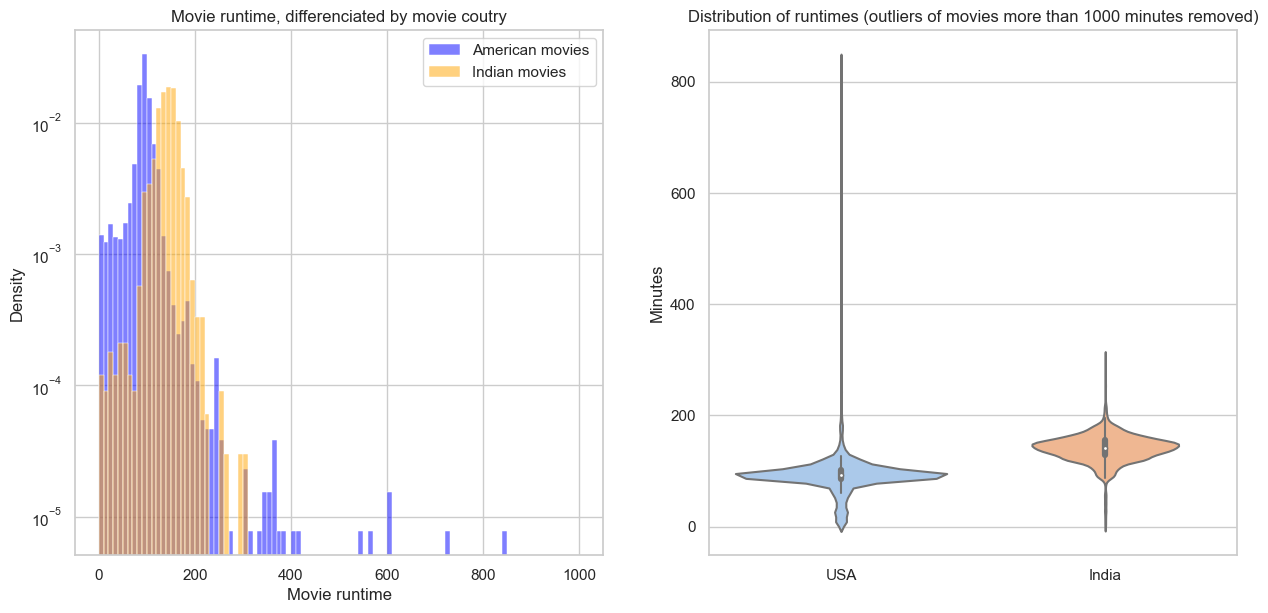

In [24]:
#defining number of bins to get roughly equal width between the 2 histograms
data_runtime = pd.DataFrame({'USA': cut_movies_american.query('movie_runtime <1000')['movie_runtime'], 'India': cut_movies_indian.query('movie_runtime<1000')['movie_runtime']})
#plotting
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
sns.histplot(cut_movies_american['movie_runtime'], alpha =.5, color = 'blue', stat = 'density', bins = 100, binrange= [0,1000], label = 'American movies')
sns.histplot(cut_movies_indian['movie_runtime'], alpha=.5, color = 'orange', stat = 'density', bins = 100, binrange= [0,1000], label = 'Indian movies')
plt.yscale('log')
plt.legend()
plt.xlabel('Movie runtime')
plt.title('Movie runtime, differenciated by movie coutry')


plt.subplot(2,2,2)
sns.violinplot(data = data_runtime, palette='pastel')
plt.ylabel('Minutes')
plt.title(f'Distribution of runtimes (outliers of movies more than 1000 minutes removed)')
plt.show()

In [25]:
print('median runtime difference:', np.nanmedian(cut_movies_american.query('movie_runtime <1000')['movie_runtime'] - cut_movies_indian.query('movie_runtime <1000')['movie_runtime']))

median runtime difference: -48.0


We notice that Indian movies have a tendency to be longer by ~48 minutes than American movies.

There could be a bias in our dataset, because early Indian cinema might be under-represented compared to early American cinema.

Although we can add that in general, Indian movies tend to have more elaborate plots and subplots, and they often include songs and dance sequences, which can contribute to their longer runtime. This is often a characteristic of Bollywood movies, in particular, which are known for their elaborate storylines and large casts. American movies, on the other hand, may be more focused on action and special effects, which may not require as much screen time. 

## Ratings

### Some global informations

In [26]:
print('%.3f percent of indian movies have a rating and %.3f percent of american movies have a rating' %
(100-np.sum(cut_movies_indian['averageRating'].isna())/cut_movies_indian.shape[0]*100, 100-np.sum(cut_movies_american['averageRating'].isna())/cut_movies_american.shape[0]*100))

print('Average rating of indian movies : %.3f \tAverage rating of american movies : %.3f' %
(np.mean(cut_movies_indian['averageRating']), np.mean(cut_movies_american['averageRating'])))

43.565 percent of indian movies have a rating and 28.535 percent of american movies have a rating
Average rating of indian movies : 6.083 	Average rating of american movies : 5.972


### Distributions of movie ratings

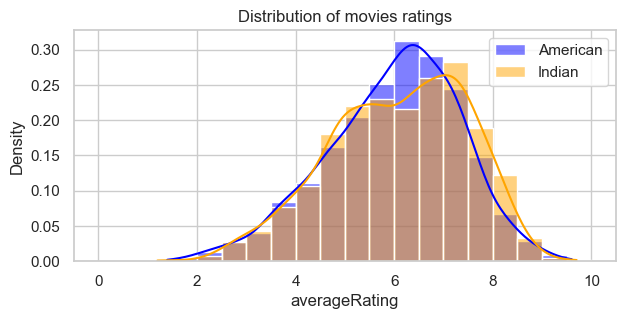

In [27]:
plt.figure(figsize=(7,3))
sns.histplot(x='averageRating', data=cut_movies_american, alpha=0.5, color = 'blue', label='American', stat = 'density', binrange=[0,10], bins = 20, kde=True)
sns.histplot(x='averageRating', data=cut_movies_indian, alpha=0.5, color='orange', stat = 'density', label='Indian', binrange=[0,10], bins = 20, kde=True)
plt.title('Distribution of movies ratings')
plt.legend()
plt.show()

In [28]:
print('P-value for normality test of american ratings : %.10f \tP-value for normality test of indian ratings : %.10f ' 
      % (st.normaltest(cut_movies_american['averageRating'], nan_policy='omit').pvalue, st.normaltest(cut_movies_indian['averageRating'], nan_policy='omit').pvalue))

P-value for normality test of american ratings : 0.0000000000 	P-value for normality test of indian ratings : 0.0000000000 


Indian and american movies get similar distributions of ratings. This will allow us to use more easily the ratings as an unbiased tool to estimate the success of a movie.

### Distribution of number of votes

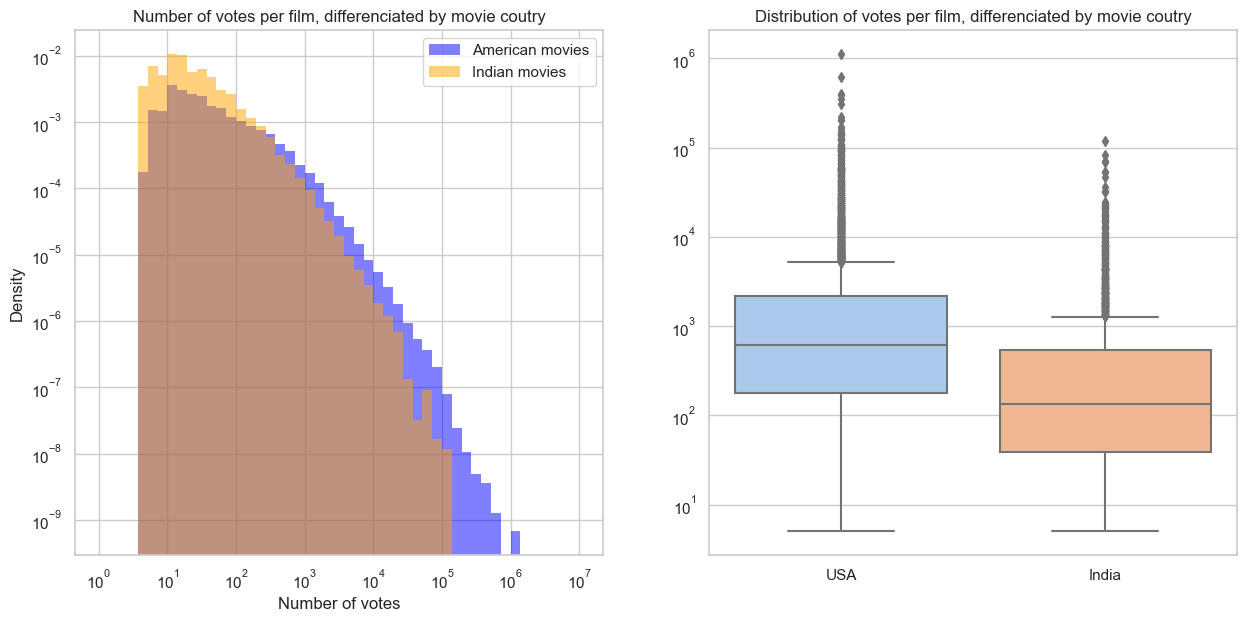

In [29]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
sns.histplot(cut_movies_american['numVotes'], bins=np.logspace(0,7,50), alpha =.5, binrange=[0., 1e7], color = 'blue', stat = 'density', label = 'American movies')
sns.histplot(cut_movies_indian['numVotes'], bins=np.logspace(0,7,50), alpha=.5, binrange=[0., 1e7], color = 'orange', stat = 'density', label = 'Indian movies')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of votes')
plt.title('Number of votes per film, differenciated by movie coutry')

plt.subplot(2,2,2)
sns.boxplot(data = pd.DataFrame({'USA': cut_movies_american['numVotes'], 'India': cut_movies_indian['numVotes']}), palette = 'pastel')
plt.yscale('log')
plt.title('Distribution of votes per film, differenciated by movie coutry')
plt.show()

In this plot we can see that the distributions follow similar patterns, except in the extremes. 

Proportionally, Indian movies have more films with few votes (less than 100 votes), and inversely, American movies have movies that exceed the maximum number of votes any indian film obtains.

In average, American films receive more votes but Indian films receive enough votes so that we can deem their ratings reliably.

### Centering the data around each means for further analysis

In [30]:
#center data on mean
cut_movies_indian.loc[:,'centeredRating']=cut_movies_indian['averageRating'].copy()-np.mean(cut_movies_indian['averageRating'])
cut_movies_american.loc[:,'centeredRating']=cut_movies_american['averageRating'].copy()-np.mean(cut_movies_american['averageRating'])
print('Centered average rating of indian movies : %.3f \tCentered average rating of american movies : %.3f' %
(np.mean(cut_movies_indian['centeredRating']), np.mean(cut_movies_american['centeredRating'])))

Centered average rating of indian movies : 0.000 	Centered average rating of american movies : 0.000


/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/3180728018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_movies_indian.loc[:,'centeredRating']=cut_movies_indian['averageRating'].copy()-np.mean(cut_movies_indian['averageRating'])
/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/3180728018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_movies_american.loc[:,'centeredRating']=cut_movies_american['averageRating'].copy()-np.mean(cut_movies_american['averageRati

## Movie genres

In [31]:
genre_indian = cut_movies_indian.copy()

#remove films without genres
genre_indian = genre_indian.query("movie_genres != ''")

genre_indian.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult,centeredRating
0,27,20604092,/m/0523t_1,anbu thozhi,2007.0,NaN,NaN,tamil language,india,romance film,NaN,NaN,0,NaN
1,30,11448183,/m/02rc_h4,bindiya chamkegi,1984.0,NaN,NaN,hindi language,india,"family film, comedy",NaN,NaN,NaN,NaN
2,31,9633533,/m/02pml15,vandanam,1989.0,NaN,168.0,malayalam language,india,action,7.9,1198.0,0,1.816751
3,35,29528534,/m/04j0lfk,anokha rishta,1986.0,NaN,180.0,hindi language,india,"world cinema, musical, drama, romantic dram...",7.3,57.0,0,1.216751
4,37,29772142,/m/0fq260_,karayilekku oru kadal dooram,2010.0,NaN,110.0,malayalam language,india,drama,6.6,15.0,0,0.516751


In [32]:
#create list with all genres and count each genre number of apparation
all_genres_listed_indian = genre_indian['movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_indian:
    ls.extend(i)
 
all_genres_indian = pd.Series(ls)
all_genres_indian = all_genres_indian.str.strip().value_counts()

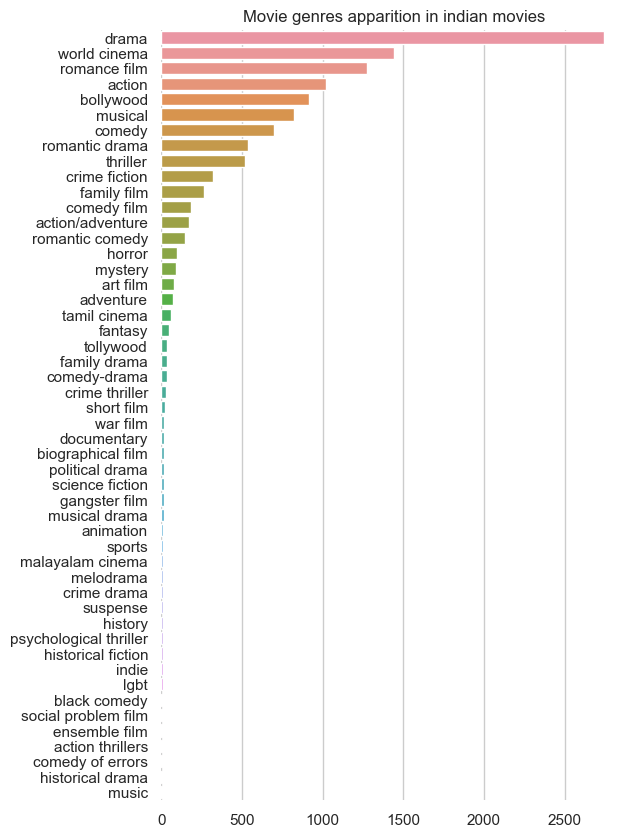

In [33]:
#ploting the first 50 genres
first_genres_indian = all_genres_indian[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_indian.index, x = first_genres_indian).set_title('Movie genres apparition in indian movies')
sns.despine(left=True, bottom=True)

In [34]:
genre_american = cut_movies_american.copy()

#remove films without genres
genre_american = genre_american.query("movie_genres != ''")
genre_american.head()

,index,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,averageRating,numVotes,isAdult,centeredRating
0,0,975900,/m/03vyhn,ghosts of mars,2001.0,14010832.0,98.0,english language,united states of america,"thriller, science fiction, horror, adventur...",NaN,NaN,NaN,NaN
1,1,3196793,/m/08yl5d,getting away with murder the jonbenét ramsey m...,2000.0,NaN,95.0,english language,united states of america,"mystery, biographical film, drama, crime drama",NaN,NaN,NaN,NaN
5,12,6631279,/m/0gffwj,little city,1997.0,NaN,93.0,english language,united states of america,"romantic comedy, ensemble film, comedy-drama...",5.8,1111.0,0,-0.172453
8,19,33420460,/m/0gj30jx,keep the change,1992.0,NaN,97.0,english language,united states of america,drama,NaN,NaN,NaN,NaN
10,21,612710,/m/02wjqm,new rose hotel,1999.0,21521.0,92.0,english language,united states of america,"thriller, science fiction, future noir, ind...",5.1,5546.0,0,-0.872453


In [35]:
#create list with all genres and count each genre number of apparation
all_genres_listed_american = genre_american['movie_genres'].str.split(pat=",")

ls = []
for i in all_genres_listed_american:
    ls.extend(i)
 
all_genres_american = pd.Series(ls)
all_genres_american = all_genres_american.str.strip().value_counts()

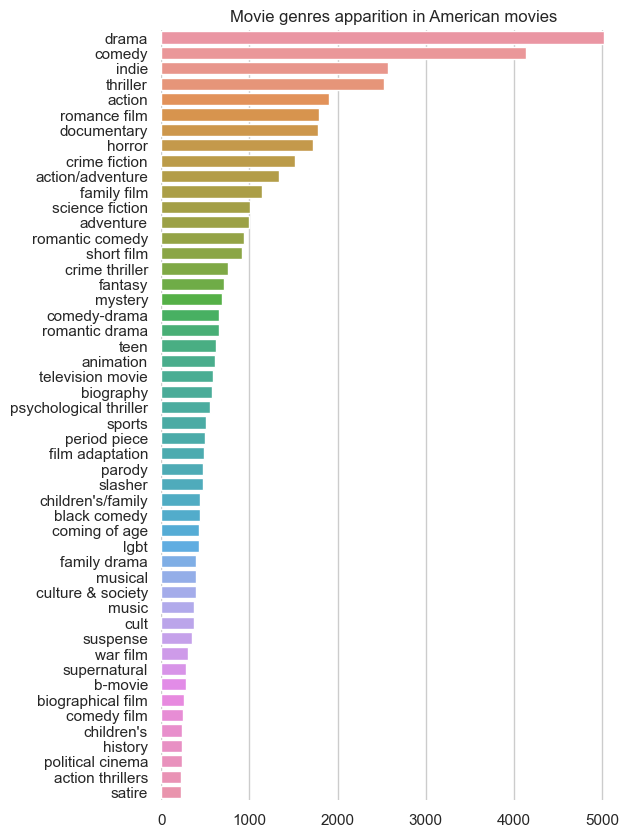

In [36]:
#ploting the first 50 genres
first_genres_american = all_genres_american[:50]
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y = first_genres_american.index, x = first_genres_american).set_title('Movie genres apparition in American movies')
sns.despine(left=True, bottom=True)


To compare them with each other, we calculate the frequency of movie genre in each country.

In [37]:
#calculate frequencies of movie genre in each country
all_genres_american_frequency = all_genres_american/len(cut_movies_american)
first_genres_american_frequency = all_genres_american_frequency[:50]
all_genres_indian_frequency = all_genres_indian/len(cut_movies_indian)
first_genres_indian_frequency = all_genres_indian_frequency[:50]

<AxesSubplot:title={'center':'India'}>

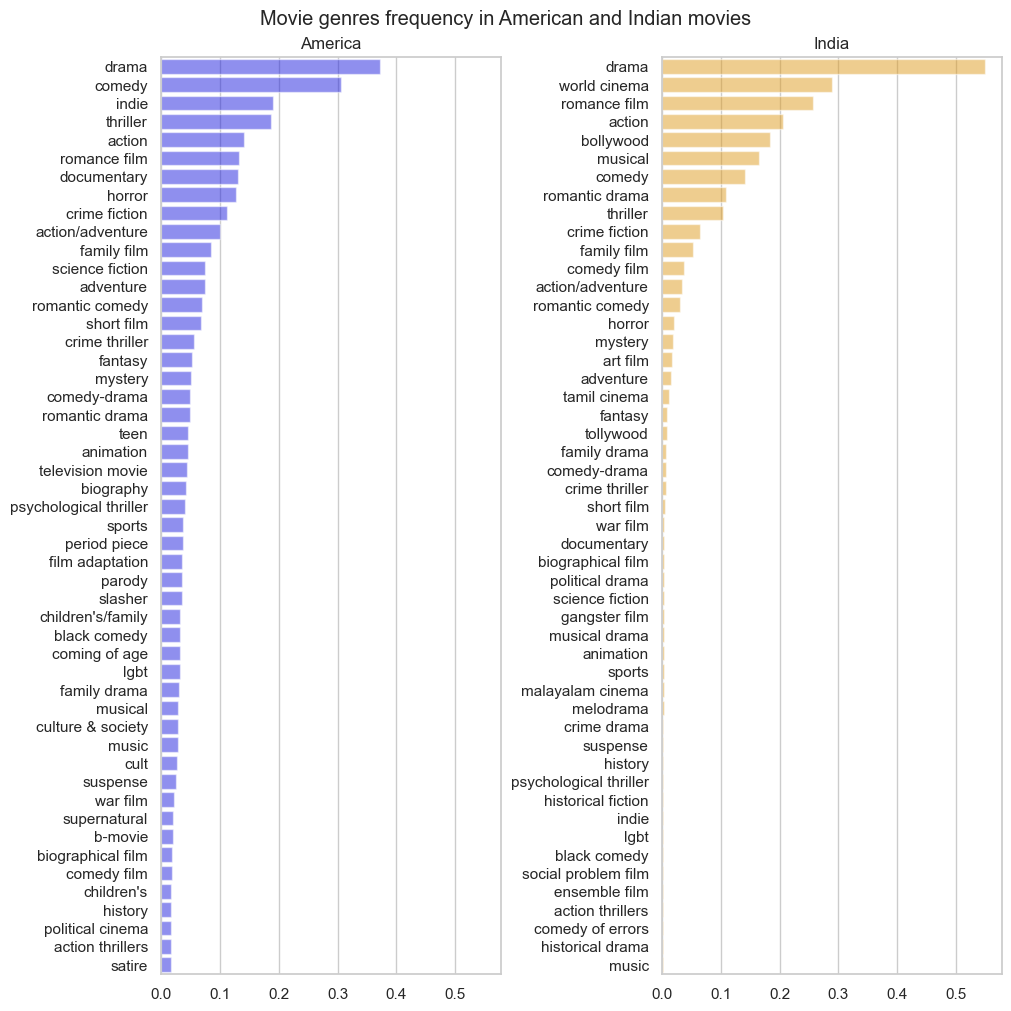

In [38]:
#plotting the first 50 genres
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in American and Indian movies')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = first_genres_american_frequency.index, x = first_genres_american_frequency, label="American", color="blue", alpha = 0.5)
sns.barplot(ax = ax[1], y = first_genres_indian_frequency.index, x = first_genres_indian_frequency, label="Indian", color="orange", alpha = 0.5)

In [39]:
print("Indian movies have in average of %d different movie genres and American movies have in average %d movie genres."  %((all_genres_indian.sum()/len(cut_movies_indian)), all_genres_american.sum()/len(cut_movies_american)))

Indian movies have in average of 2 different movie genres and American movies have in average 4 movie genres.


As the plot shows, "drama" is the prominent movie genre in both American and Indian movies. 
American movies seems to have a better distribution of different genres than Indian movies, that are more focused around "drama".
Some questions arises here : is American drama the same as Indian drama ? What if these notions are completely different in both culture ? We will investigate further these questions in the end of our analysis.

Furthermore, both of Indian and American movies have a large number of movie genres, so it could be interesting to select a restricted group of movie genres that allows better and more precise results for our further analysis.

For example, genre like "world cinema" seems rather not specific enough to categorize the movies. Indeed, the term "world cinema" refers to films produced outside of the United States and Europe, or to films that are made in a particular country or region but are intended for international audiences. World cinema includes a wide variety of film genres, such as action, drama, comedy, romance, horror, and more. It encompasses films from many different countries and cultures, each with their own unique traditions and styles of storytelling.

It is rather reducer to put every genre produced outside of the Occident in a global term like "world cinema". We hence lose loads of information about the spectrum of differences and different themes of movies produced around the world. This could be another bias that our data set has, on the fact that Indian movies are not represented the same way as American movies.

This could explain the fact that there is more movie genres attributed to American movies than Indian movies, although we have to be careful of the fact that we have less Indian movies than American movies.

Finally, some genres are similar to each other or some of them include other genres (e.g. "action/aventure"). For these types of genres, we separated them and re-classified them in each one of the single genres.

## Movie languages

### Languagues in Indian movies

In [40]:
indian_languages= cut_movies_indian.copy()

#remove the films without any languages
indian_languages = indian_languages.query("movie_languages != ''")

In [41]:
#Create a list with all languages
all_languages_listed_indian = indian_languages['movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_indian = all_languages_listed_indian.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_indian:
    ls.extend(i)
 
#Count the total number of languages that are in the movies for each one of the languages
all_languages_indian = pd.Series(ls)

#Strip the strings and count the numbers of occurence of each languages
all_languages_indian = all_languages_indian.str.strip().value_counts()

all_languages_indian.head()

hindi language        1977
tamil language        1131
malayalam language     815
telugu language        685
bengali language       195
dtype: int64

In [42]:
all_languages_indian_code = all_languages_indian.copy()

#Put it as data frame
all_languages_indian_code= pd.DataFrame(all_languages_indian_code)

#Reset the index to have the index as column
all_languages_indian_code = all_languages_indian_code.reset_index()

#Rename the columns correctly
all_languages_indian_code = all_languages_indian_code.rename(columns={"index": "languages", 0:"count"})

#Only take the top 20 languages to plot it 
top_20_ind = all_languages_indian_code.iloc[:20]

top_20_ind.head()

,languages,count
0,hindi language,1977
1,tamil language,1131
2,malayalam language,815
3,telugu language,685
4,bengali language,195


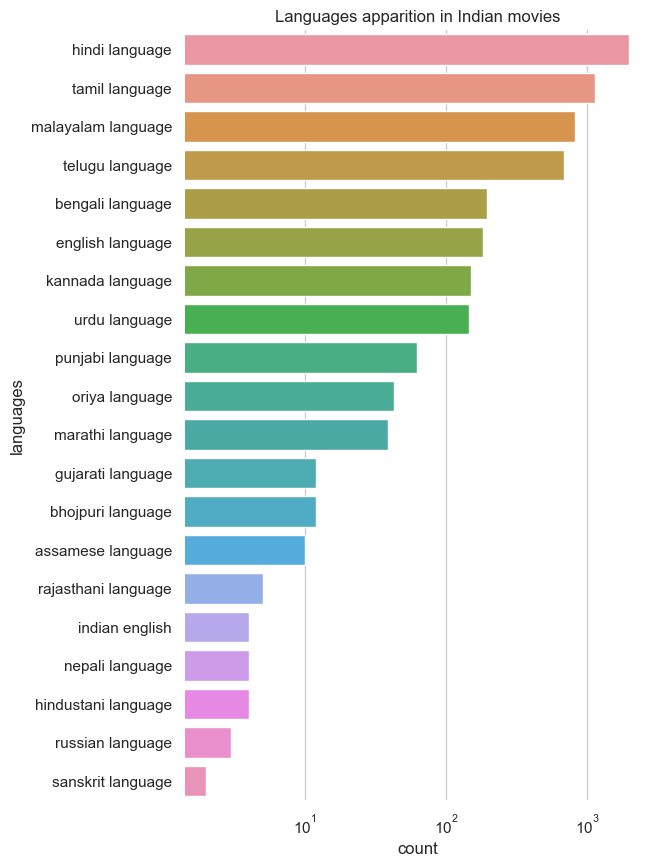

In [43]:
#Plotting top 20 languages (39 in total for indian languages)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_ind,y = 'languages', x = 'count').set_title('Languages apparition in Indian movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### Languagues in American movies

In [44]:
american_languages = cut_movies_american.copy()

#Remove films without languages
american_languages = american_languages.query("movie_languages != ''")

In [45]:
#Create list with all languages
all_languages_listed_american = american_languages['movie_languages'].str.split(pat=",")

#Drop the NAs
all_languages_listed_american = all_languages_listed_american.dropna()

#Create a list with all the languages in it
ls = []
for i in all_languages_listed_american:
    ls.extend(i)
 
all_languages_american = pd.Series(ls)

#Count the total number of languages that are in the movies for each one of the languages
all_languages_american = all_languages_american.str.strip().value_counts()

all_languages_american.head()

english language    12083
spanish language      295
french language       180
german language       116
italian language       94
dtype: int64

In [46]:
all_languages_american_code =  all_languages_american.copy()

#Put it as data frame
all_languages_american_code = pd.DataFrame(all_languages_american_code)

#Reset the index to have the index as column
all_languages_american_code = all_languages_american_code.reset_index()

#Rename the columns correctly
all_languages_american_code = all_languages_american_code.rename(columns={"index": "languages", 0:"count"})

#Only take the top 20 languages to plot it 
top_20_american = all_languages_american_code.iloc[:20]

top_20_american.head()

,languages,count
0,english language,12083
1,spanish language,295
2,french language,180
3,german language,116
4,italian language,94


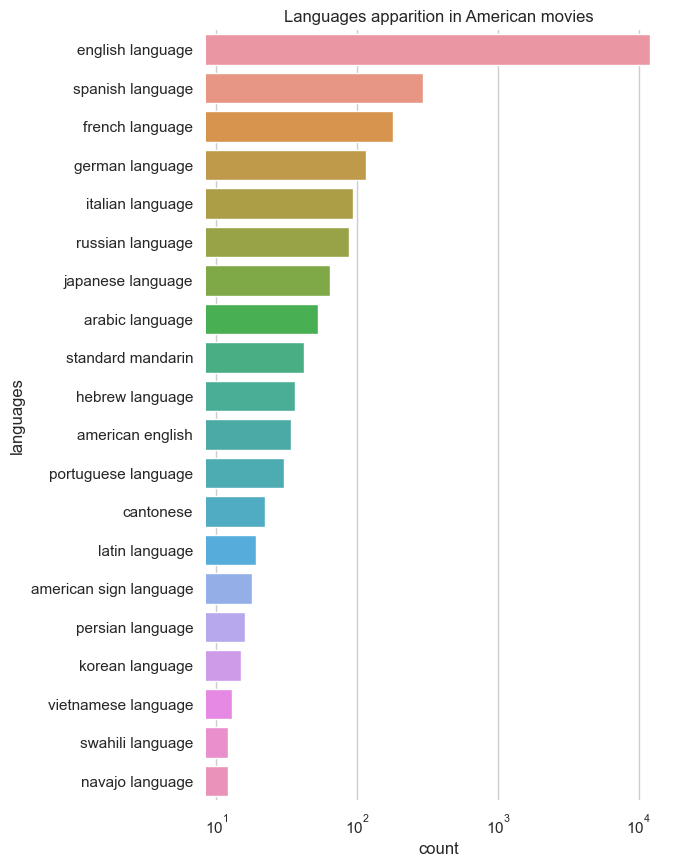

In [47]:
#Plotting top 20 languages (111 in total for American movies)
f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(data = top_20_american, y = 'languages', x = 'count').set_title('Languages apparition in American movies')
ax.set_xscale('log')
sns.despine(left=True, bottom=True)

### Comparaison of languages between Indian and American movies

In [48]:
#Compute the frequency of top 20 for the American and Indian languages
all_languages_american_code['frequency'] = all_languages_american_code['count'] / all_languages_american_code['count'].sum()
first_languages_american_frequency = all_languages_american_code[:20]

all_languages_indian_code['frequency'] = all_languages_indian_code['count']/all_languages_indian_code['count'].sum()
first_languages_indian_frequency = all_languages_indian_code[:20]


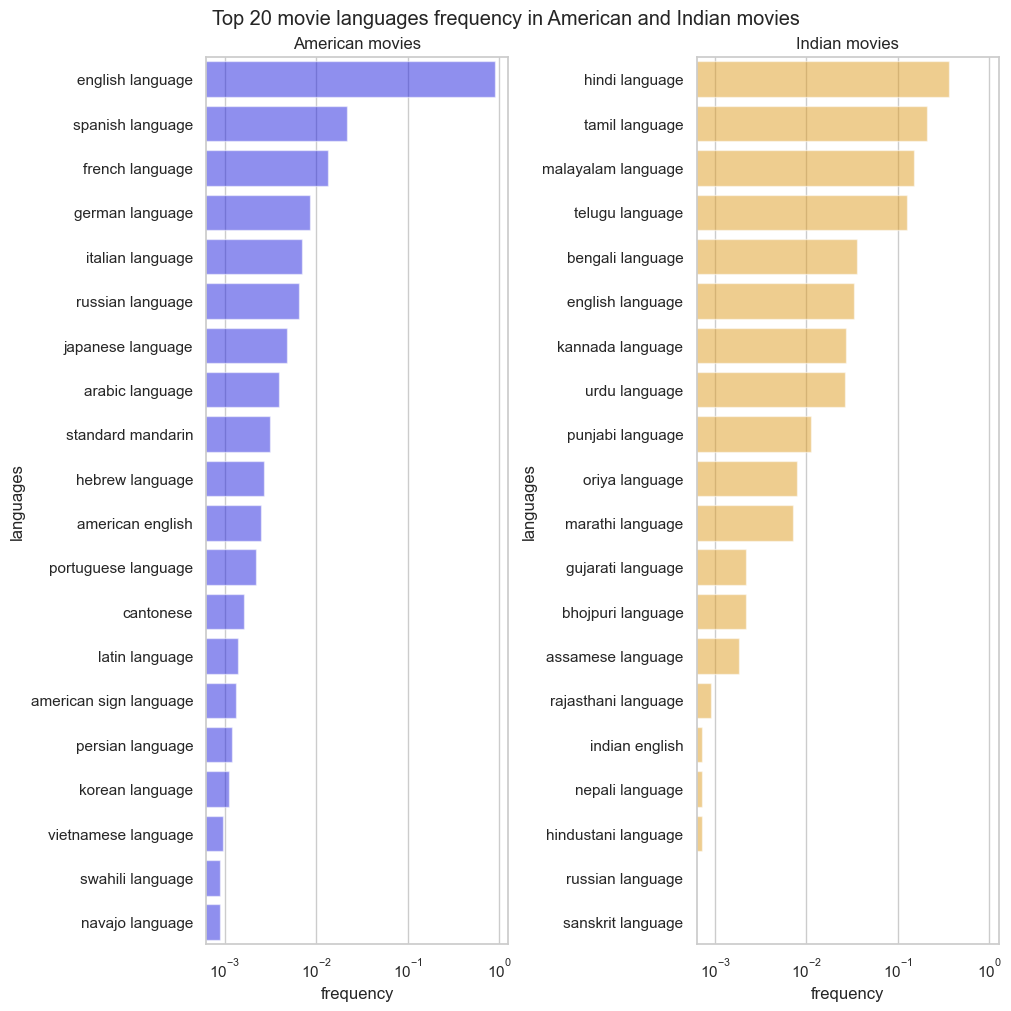

In [49]:
#Plotting taking the first 20 languages for American films and Indian movies
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Top 20 movie languages frequency in American and Indian movies')
ax[0].set_title('American movies')
ax[1].set_title('Indian movies')

sns.barplot(ax = ax[0],data = first_languages_american_frequency, y = 'languages', x = 'frequency', label="American", color="blue", alpha = 0.5)

sns.barplot(ax = ax[1], data = first_languages_indian_frequency, y = 'languages', x = 'frequency', label="Indian", color="orange", alpha = 0.5)

#Setting logarithmic scale 
ax[0].set_xscale('log')
ax[1].set_xscale('log')

Indian movies are typically made in a variety of languages, with the most common being Hindi, Tamil, Telugu, and Kannada. Many Indian movies are also made in regional languages, such as Bengali, Marathi, and Malayalam, and they may be released in multiple languages to appeal to a wider audience. In addition, many Indian movies are dubbed into other languages for international distribution.

American movies tends to have more languages that are spoken around the world. It is typically made in English, although there are also many American movies that are made in other languages or that feature actors speaking in languages other than English, like spanish or french. In recent years, there has been an increase in the number of American movies that feature multilingual casts and storylines, reflecting the diversity of the United States and the global nature of the film industry.

### How many languages per movies there are, on average ?


In [50]:
#Compute the number of ':' that represent the number of languages there are in each row for American movies
american_languages['n_languages'] = american_languages.movie_languages.str.count(',')

#Compute the number of ':' that represent the number of languages there are in each row for Indian movies
indian_languages['n_languages'] = indian_languages.movie_languages.str.count(',')

In [51]:
#Drop the movies that do not have any languages
n_indian_lan = indian_languages['n_languages'].dropna()

n_american_lan = american_languages['n_languages'].dropna()

#Compute the t-test to compare the number of available languages per movies for Indian and American movies
t_test_languages = st.ttest_ind(n_indian_lan, n_american_lan)

print('p-value for languages: ',t_test_languages.pvalue, '\t', 'p-value is smaller than 0.05: ', t_test_languages.pvalue <0.05)

p-value for languages:  0.08414254746633416 	 p-value is smaller than 0.05:  False


There is a significant difference of the numbers of languages spoken in American vs Indian movies, but it is hard to pinpoint the underlying effect of this latter. 

We could jump on the conclusion that American movies tend to be more international and are more exported abroad that Indian movies, in general, thus having more languages available.

Although, it is worth noting that the export and distribution of movies can be a complex process, and there are many factors that can influence a film's success in different markets (quality of the film, the subject matter, and the demand for the film in different countries, ...).

While the language of a movie may be one factor that can affect its distribution, it is not the only factor, and many Indian movies have been widely exported and enjoyed by audiences around the world regardless of the language in which they were made.

## Actors

In [52]:
# We split the dataset in two:
# 1. all_american_actors which can contain duplicate actors. It contains information about the movies
# and who plays in it and the age of the actors when the film is produced
#
# 2. all_indian_actors that contains data about individual actors. It doesn't contain duplicates,

all_american_actors = characters_data[characters_data['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]
all_indian_actors = characters_data[characters_data['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]

unique_american_actor = all_american_actors.drop_duplicates('actor_name')
unique_indian_actor = all_indian_actors.drop_duplicates('actor_name')

In [53]:
# We add a column indicating the country the actor/actress works in before concatenating the datasets
unique_american_actor = unique_american_actor.assign(country = np.full(len(unique_american_actor), 'USA'))
unique_indian_actor = unique_indian_actor.assign(country = np.full(len(unique_indian_actor), 'India'))

all_american_actors = all_american_actors.assign(country = np.full(len(all_american_actors), 'USA'))
all_indian_actors = all_indian_actors.assign(country = np.full(len(all_indian_actors), 'India'))

# We make sure to only keep actors with positive age to get rid of the errors 
all_american_actors = all_american_actors[all_american_actors['actor_age_at_movie_release'] > 0.]
all_indian_actors = all_indian_actors[all_indian_actors['actor_age_at_movie_release'] > 0.]

feature_list_all_actors = ['actor_gender', 'actor_age_at_movie_release', 'country']
all_actors_merged = pd.concat([all_american_actors[feature_list_all_actors], all_indian_actors[feature_list_all_actors]], axis = 0)

feature_list_unique_actors = ['actor_name', 'actor_gender', 'actor_ethnicity', 'country']
unique_actors_merged = pd.concat([unique_american_actor[feature_list_unique_actors], unique_indian_actor[feature_list_unique_actors]], axis = 0)

# Adding a column to the dataset of the features of single actors for the number of films in our dataset they appear in
dict_number_of_film = characters_data['actor_name'].value_counts().to_dict()
unique_actors_merged['number_of_films'] = unique_actors_merged['actor_name'].map(dict_number_of_film)

In [54]:
all_actors_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109491 entries, 0 to 450590
Data columns (total 3 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   actor_gender                109069 non-null  object 
 1   actor_age_at_movie_release  109491 non-null  float64
 2   country                     109491 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.3+ MB


In [55]:
unique_actors_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46772 entries, 0 to 450077
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   actor_name       46770 non-null  object 
 1   actor_gender     35411 non-null  object 
 2   actor_ethnicity  2032 non-null   object 
 3   country          46772 non-null  object 
 4   number_of_films  46770 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.1+ MB


### Age

To do the analysis on age, it makes sense to count the same actors multiple times as they play in different films, we will thus not drop the duplicates for this part of the analysis.

In [56]:
print(all_american_actors.actor_age_at_movie_release.describe())
print(all_indian_actors.actor_age_at_movie_release.describe())

count    86633.000000
mean        39.014394
std         15.040967
min          1.000000
25%         28.000000
50%         37.000000
75%         49.000000
max         97.000000
Name: actor_age_at_movie_release, dtype: float64
count    22858.000000
mean        37.016537
std         13.418025
min          1.000000
25%         26.000000
50%         35.000000
75%         46.000000
max         97.000000
Name: actor_age_at_movie_release, dtype: float64


We can see that the mean age is similar in both cases, as well as the standard deviation. Looking at the different quartiles we cannot see significant distribution difference between the two groups. 

We can note, however, that we have significantly more available ages available for actors in American films as for actors in Indian films (86'633 versus 22'858)

In [57]:
st.ttest_ind(all_american_actors.actor_age_at_movie_release, all_indian_actors.actor_age_at_movie_release, equal_var=False)

Ttest_indResult(statistic=19.508266935187176, pvalue=2.339630207961326e-84)

We can reject the null hypothesis, that is, that the mean actor age from American and Indian movies are the same.

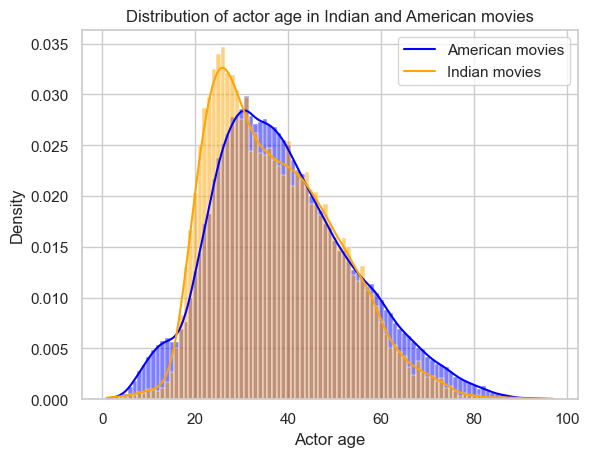

In [58]:
sns.histplot(data = all_american_actors['actor_age_at_movie_release'], stat = 'density', discrete=True, color = 'blue', kde=True, alpha = 0.5)
sns.histplot(data = all_indian_actors['actor_age_at_movie_release'], stat = 'density',discrete=True, color='orange', kde=True, alpha = 0.5)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Actor age')
plt.title('Distribution of actor age in Indian and American movies')
plt.show()

There seems to be more teenagers cast in american films, this can be due to the popularity of 'teen movies' in the western world, but is more likely to be simply due to a bias in quantity of information about american movies. 

The wikipedia pages of American movies might be more detailed about American films, containing even information about characters that may have relatively low screen time, like the daughter of a secondary character etc..

Otherwise the distributions seem similar.

### Gender

In [59]:
# We separate the datasets containing all actors by gender
# For american films
american_film_female = all_american_actors[all_american_actors['actor_gender'] == 'F']
american_film_male = all_american_actors[all_american_actors['actor_gender'] == 'M']

# And for indian films
indian_film_female = all_indian_actors[all_indian_actors['actor_gender'] == 'F']
indian_film_male = all_indian_actors[all_indian_actors['actor_gender'] == 'M']


In [60]:
print('Number of american film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(american_film_male) + len(american_film_female), len(american_film_female)/(len(american_film_male) + len(american_film_female))))

print('Number of indian film actors we have the gender of is {0}, of which {1:.0%} are female'.format(
    len(indian_film_male) + len(indian_film_female), len(indian_film_female)/(len(indian_film_male) + len(indian_film_female))))

Number of american film actors we have the gender of is 86227, of which 34% are female
Number of indian film actors we have the gender of is 22842, of which 35% are female


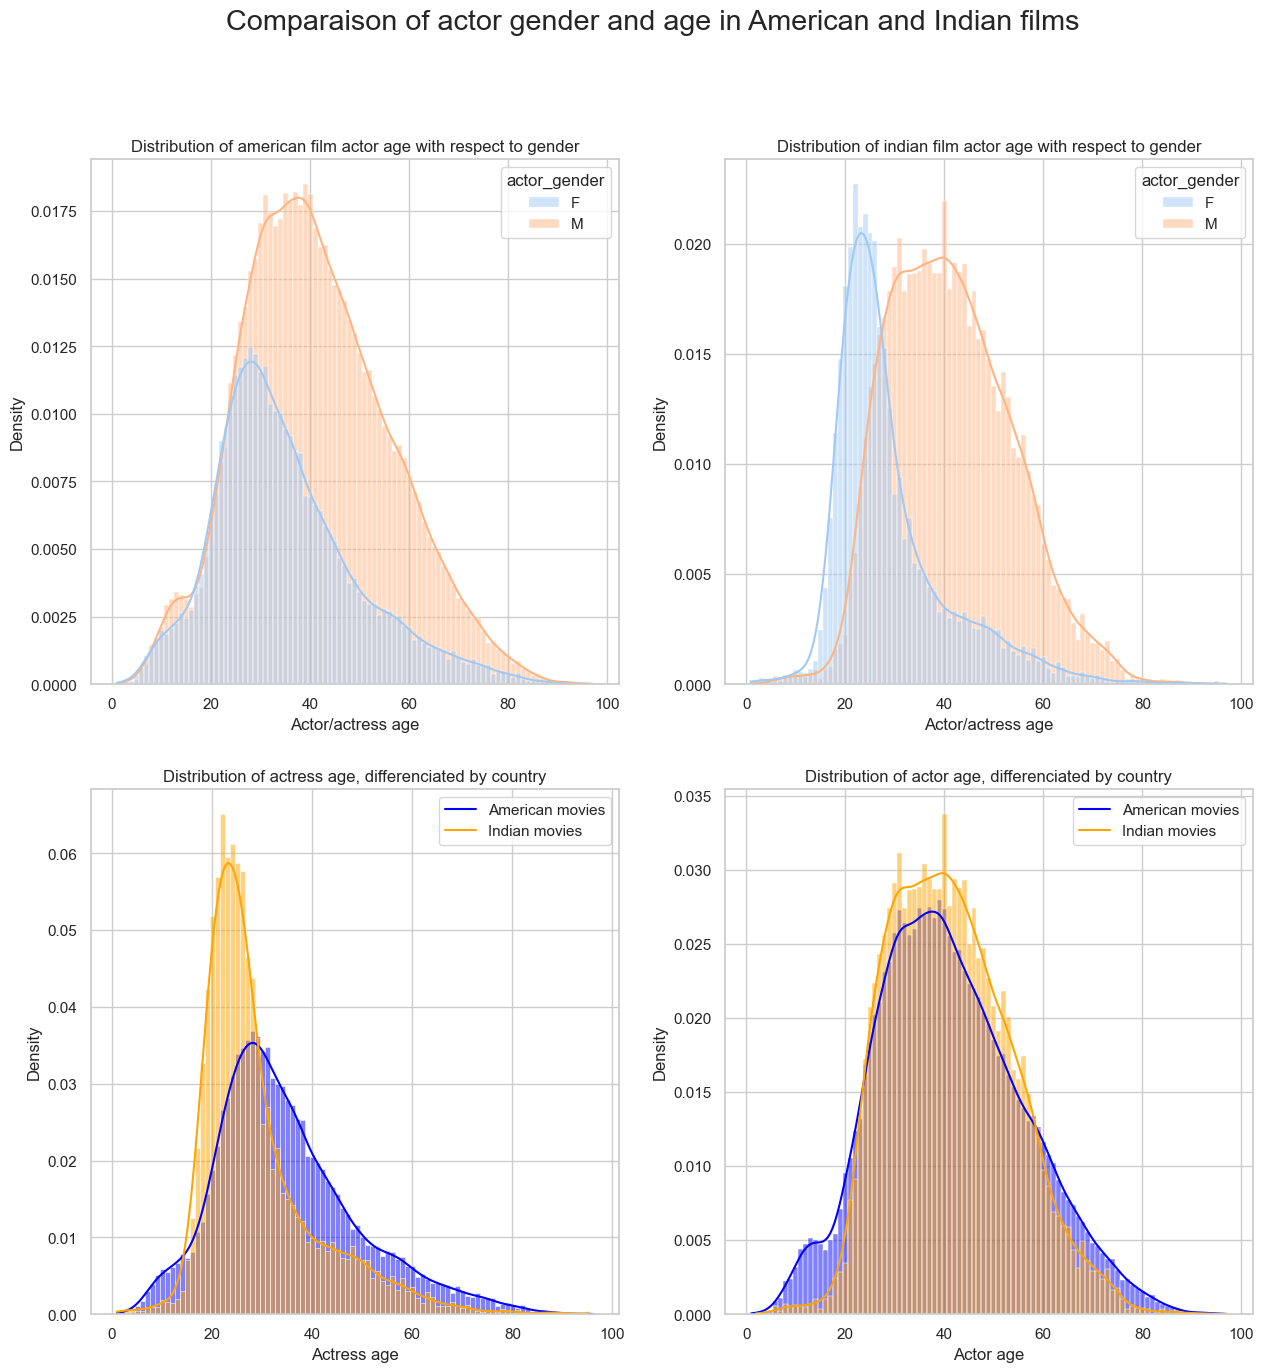

In [61]:
plt.figure(figsize=(15,15))
plt.suptitle('Comparaison of actor gender and age in American and Indian films', size = 'xx-large')
plt.subplot(2,2,1)

sns.histplot(data = all_american_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True, palette = 'pastel')
plt.xlabel('Actor/actress age')
plt.title('Distribution of american film actor age with respect to gender')

plt.subplot(2,2,2)
sns.histplot(data = all_indian_actors, x = 'actor_age_at_movie_release', hue = 'actor_gender', stat = 'density', discrete=True, kde=True, palette = 'pastel')

plt.xlabel('Actor/actress age')
plt.title('Distribution of indian film actor age with respect to gender')

plt.subplot(2,2,3)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='blue', kde=True, alpha = 0.5)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'F'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True, color = 'orange', alpha = 0.5)
plt.xlabel('Actress age')
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actress age, differenciated by country')

plt.subplot(2,2,4)
sns.histplot(data = all_american_actors[all_american_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, color='blue', kde=True, alpha = 0.5)
sns.histplot(data = all_indian_actors[all_indian_actors['actor_gender'] == 'M'], x = 'actor_age_at_movie_release', stat = 'density', discrete=True, kde=True, color = 'orange', alpha = 0.5)
plt.xlabel('Actor age')
plt.legend(labels=["American movies","Indian movies"])
plt.title('Distribution of actor age, differenciated by country')
plt.show()

We can also visualize the same phenomenon using boxplots

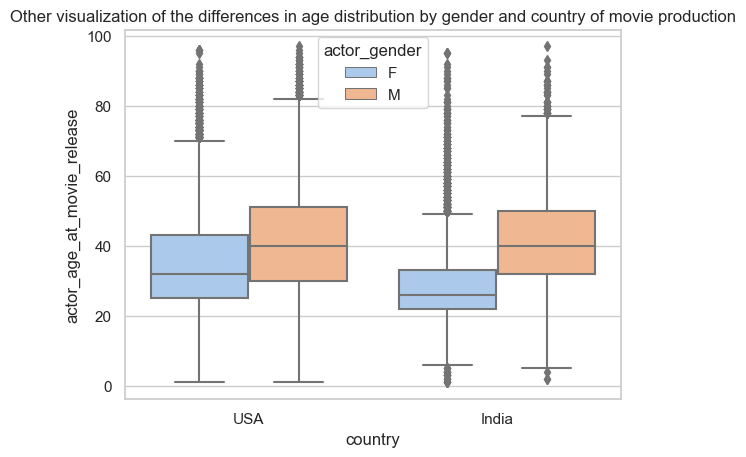

In [62]:
sns.boxplot(data = all_actors_merged, y = 'actor_age_at_movie_release', x = 'country', hue= 'actor_gender', palette = 'pastel')
plt.title('Other visualization of the differences in age distribution by gender and country of movie production')
plt.show()

There are very little differences between the distributions of actor age between the two movie industries, but a big difference between the distribution of actresses' age. 
We can see that in indian movies there is a big density peak in the low twenties and a rapid decline from the thirties onward. 

This difference is very stark and should be investigated further in the rest of our analysis, regarding time-wise changes and the prediction of movie success.

We can evaluate the significance of the difference between the mean age of actors and actresses.

In [63]:
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'F']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'F']['actor_age_at_movie_release']))
print(st.ttest_ind(all_american_actors.loc[all_american_actors.actor_gender == 'M']['actor_age_at_movie_release'],all_indian_actors.loc[all_indian_actors.actor_gender == 'M']['actor_age_at_movie_release']))

Ttest_indResult(statistic=-58.62200168293419, pvalue=0.0)
Ttest_indResult(statistic=-72.08058438039822, pvalue=0.0)
Ttest_indResult(statistic=33.114262766644856, pvalue=5.284351356623758e-237)
Ttest_indResult(statistic=-0.8159234566308474, pvalue=0.41454661681263116)


Let us use the Bonferroni correction since we are doing multi-hypothesis testing: our p corrected value is equal to p/4 = 0.05/4 = 0.0125.
As we can see, all the p-value are significant except the t-test that compares the male ages of actors in Indian and American movies.

The difference between actress in Indian and in American is significant, it could have thus underlying effects, even though it might mainly be driven by the sample size.

Although, we can propose some possible factors to explain why Indian actresses might be younger than the American actresses:

- Cultural preferences: In some cultures, including Indian culture, youth and beauty are often prized and valued highly. This may lead to a preference for younger actresses in the film industry.

- The demands of the film industry: Acting in movies can be physically demanding, and younger actresses may be better able to handle the demands of long shooting schedules and demanding roles.

- Physical demands of acting: In some cases, certain roles may require actresses to have a certain appearance or physicality, which may be more common in younger actresses.

It is also worth noting that there is a wide range of ages among actresses in Indian movies, and many actresses in India continue to work in the film industry well into their 40s, 50s, and beyond.

### Ethnicity

In [64]:
ethnicity_data = unique_actors_merged.groupby(['actor_ethnicity', 'country'], as_index=False)['actor_name'].agg({'count'})
ethnicity_data = pd.DataFrame(ethnicity_data.to_records())
ethnicity_data = ethnicity_data.set_index('actor_ethnicity')

#separate the dataset per country
ethnicity_data_india = ethnicity_data[ethnicity_data['country'] == 'India']
ethnicity_data_usa = ethnicity_data[ethnicity_data['country'] == 'USA']

# converting count into density
ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)

ethnicity_data.head()

/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/55783346.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnicity_data_india['count'] = ethnicity_data_india.loc[:,'count'].div(len(ethnicity_data_india)).copy(deep=True)
/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/55783346.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnicity_data_usa['count'] = ethnicity_data_usa.loc[:,'count'].div(len(ethnicity_data_usa)).copy(deep=True)


,country,count
actor_ethnicity,,
Acadians,USA,1
Afghans in India,India,5
Afrikaners,USA,1
Afro Trinidadians and Tobagonians,USA,2
Afro-Cuban,USA,1


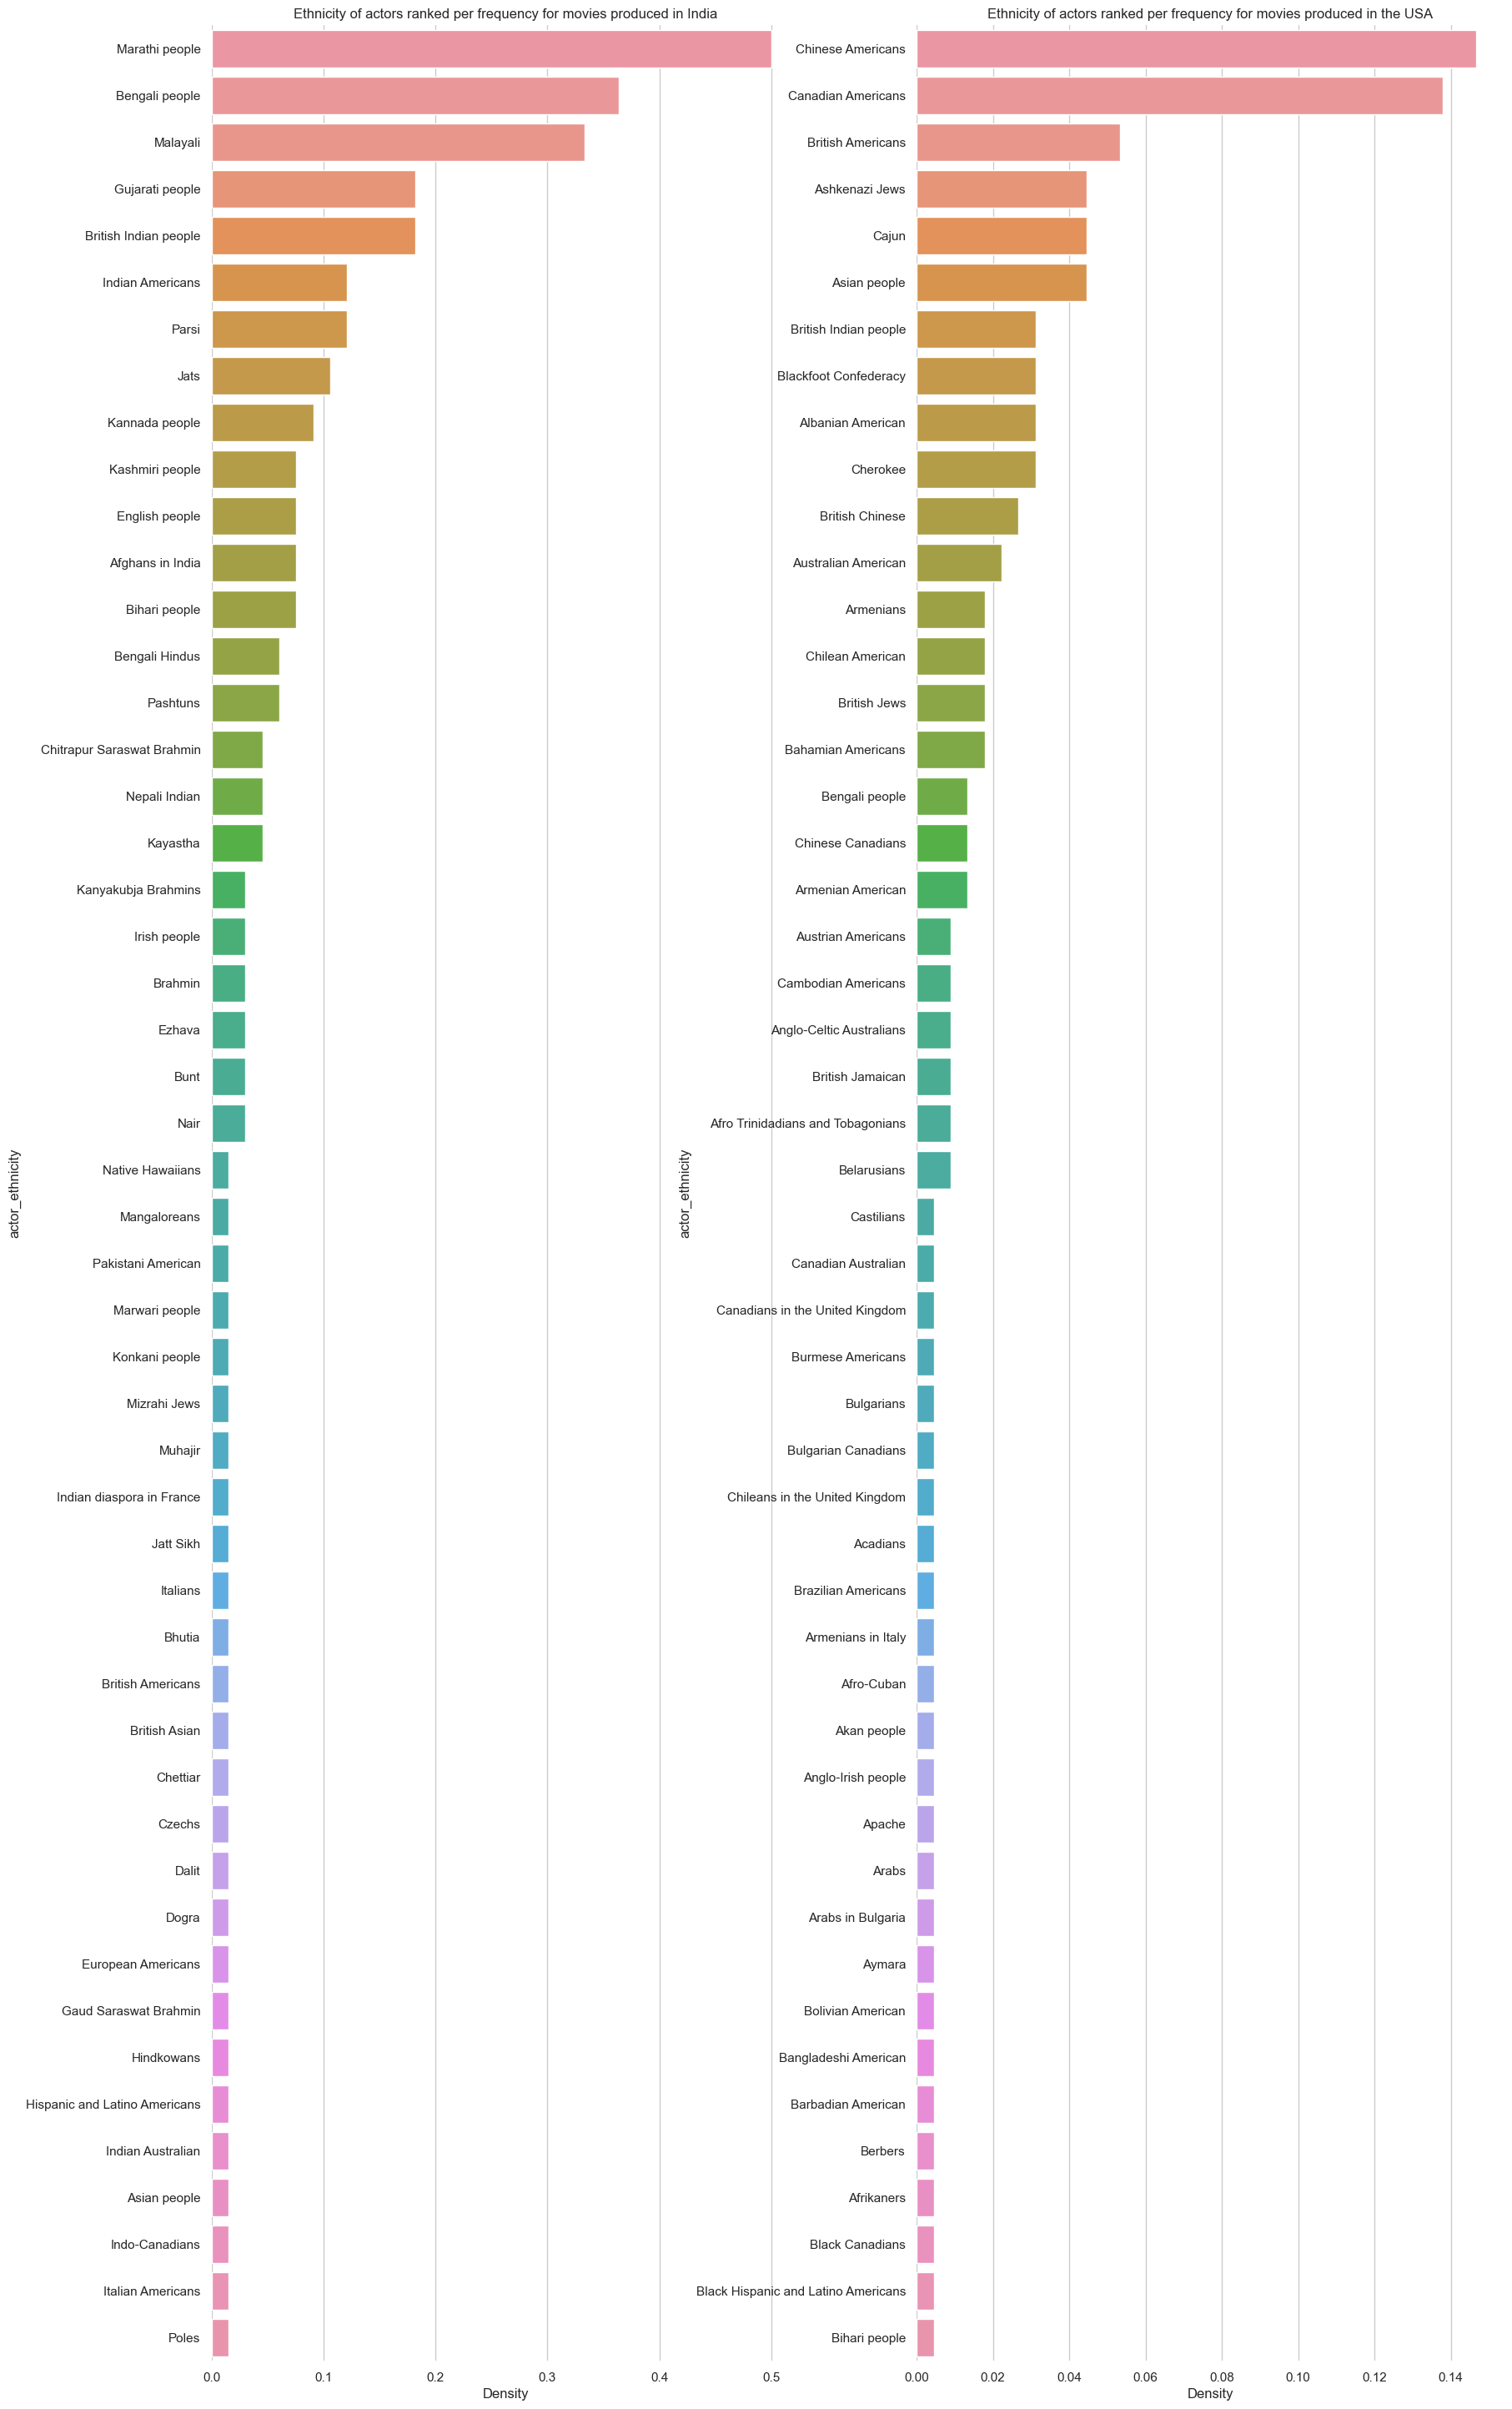

In [65]:
plt.figure(figsize=(20,80))
plt.subplot(2,2,1)
plt.title('Ethnicity of actors ranked per frequency for movies produced in India')
sns.barplot(data = ethnicity_data_india[:50], y = ethnicity_data_india.index[:50],  x = 'count', orient='h', order=ethnicity_data_india[:50].sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')


plt.subplot(2,2,2)
plt.title('Ethnicity of actors ranked per frequency for movies produced in the USA')
sns.barplot(data = ethnicity_data_usa[:50], y = ethnicity_data_usa.index[:50],  x = 'count', orient='h', order=ethnicity_data_usa[:50].sort_values(by = 'count', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Density')

plt.show()

In [66]:
print('Number of ethnicities in Indian movies:',len(ethnicity_data_india), '\nNumber of ethnicities in American movies:',len(ethnicity_data_usa))

Number of ethnicities in Indian movies: 66 
Number of ethnicities in American movies: 225


Unsurprisingly, most ethnicities represented in the American films are descendent of immigrants, and most ethnicities represented in Indian films are Indian or more generally south-Asian. 

Also unsurprisingly, there are a lot more different ethnicities represented in films produced in the US compared to films produced in India. This might be due to the US being a more cosmopolite country, and to the difference in amout of information we have in our dataset

We can try investigate further the differences in representations in the industies, looking at the ethnicities represented in both industries

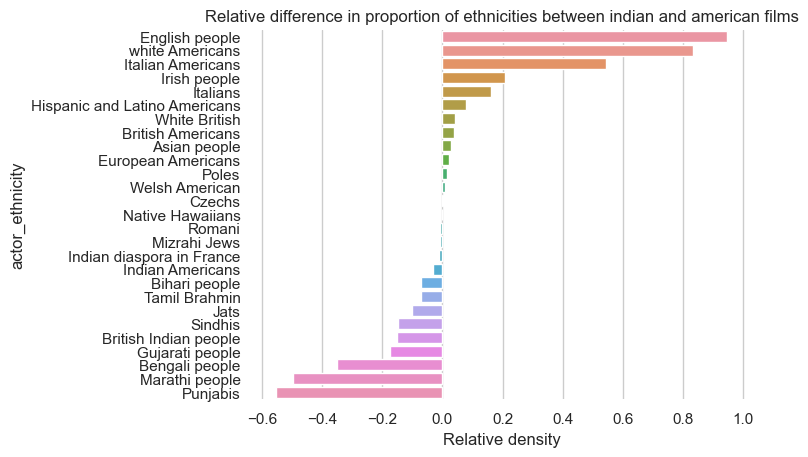

In [67]:
# negative values represent ethnicities more represented in the indian film industry, and vice versa
compared_ethnicities = (ethnicity_data_usa['count'] - ethnicity_data_india['count']).dropna()

plt.title('Relative difference in proportion of ethnicities between indian and american films')
sns.barplot(y = compared_ethnicities.index,  x = compared_ethnicities.values, orient='h', order=compared_ethnicities.sort_values(ascending=False).index)
sns.despine(left=True, bottom=True)
plt.xlabel('Relative density')
plt.show()

In [68]:
print('Number of indian film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'India'].dropna().shape[0])
print('Number of american film actors we have every features for:', unique_actors_merged[unique_actors_merged['country'] == 'USA'].dropna().shape[0])

Number of indian film actors we have every features for: 325
Number of american film actors we have every features for: 1707


In [69]:
print('Number of indian film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'India']['actor_gender'].shape[0])
print('Number of american film actors we have everything but ethnicity for:', unique_actors_merged[unique_actors_merged['country'] == 'USA']['actor_gender'].shape[0])

Number of indian film actors we have everything but ethnicity for: 4541
Number of american film actors we have everything but ethnicity for: 42231


If we consider only actors where we have all the available informations (gender, country the actors plays in, and ethnicity) we only get 325 indian film actors and 1707 american film actors. This is not enough to perform an analysis through time while taking into account actor ethnicity.

On the other hand, we have substantially more data on gender so taking it into account could be interesting for the subsequent analysis.

### In how many films an actor/actress have played in?

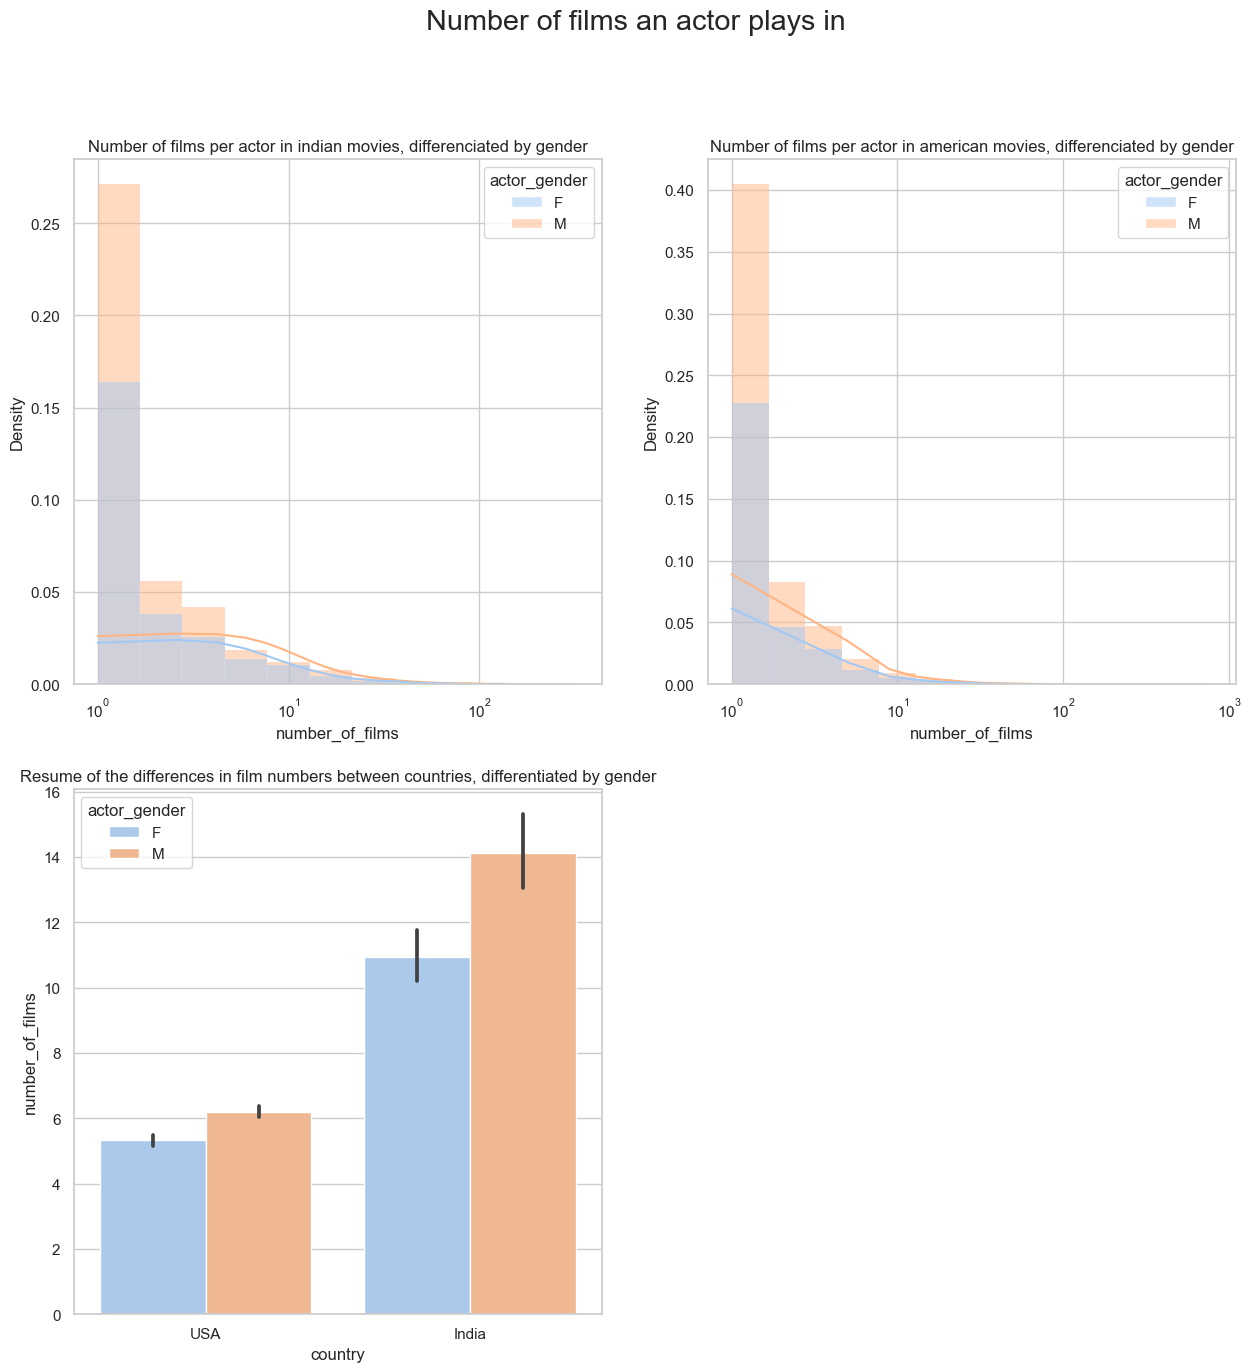

In [70]:
plt.figure(figsize=(15,15))
plt.suptitle('Number of films an actor plays in', size = 'xx-large')
plt.subplot(2,2,1)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'India'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density', palette = 'pastel').set(xscale="log")
plt.title('Number of films per actor in indian movies, differenciated by gender')
plt.subplot(2,2,2)
sns.histplot(data = unique_actors_merged[unique_actors_merged['country'] == 'USA'], bins = np.logspace(0,2, 10), x = 'number_of_films', hue = 'actor_gender', kde = True, stat = 'density', palette = 'pastel').set(xscale="log")
plt.title('Number of films per actor in american movies, differenciated by gender')

plt.subplot(2,2,3)
sns.barplot(data = unique_actors_merged, y = 'number_of_films', x = 'country', hue= 'actor_gender', palette = 'pastel')
plt.title('Resume of the differences in film numbers between countries, differentiated by gender')
plt.show()

In [71]:
# counting the number of actors/actresses that have played in more than 100 movies
unique_actors_merged[unique_actors_merged['number_of_films'] > 100].groupby(['country', 'actor_gender']).agg({'count'})

actor_name actor_ethnicity number_of_films
                          count           count           count
country actor_gender                                           
India   F                     5               1               5
        M                    44              14              44
USA     F                     2               0               2
        M                    21               7              21

We probably have a bias in our dataset in the quantity of information we have in our dataset regarding the American films. 
We are far more likely to have the names of actors that make a single brief appearance in an American film. 
However, regarding the other extreme, we can see that there is a lot more ultra-prolific Indian film actors than American film actors.

In both film industries we see however that most of the hyper-prolific actors are males, which is probably linked to the difference in career prospects with age.

Also, there is some evidence to suggest that female actresses tend to have fewer opportunities to play leading roles in movies than male actors in both Hollywood and Bollywood. Indeed, in 2015, the Center for the Study of Women in Television and Film at San Diego State University published a report titled "It's a Man's (Celluloid) World," which found that women made up just 12% of protagonists in the top 100 grossing films of 2014.

This phenomenon, known as the "gender gap" or the "female movie deficit," refers to the underrepresentation of women in the film industry, both in front of and behind the camera.

There are also more factors that may contribute to the gender gap in the film industry, including societal and cultural biases, the lack of diverse and complex female characters in film scripts, and the limited number of female directors and producers.

This is once again an angle that could be included in further analysis regarding trends and film success (ratings) prediction.

## Topics analysis in summaries

We split our data in Indian and American dataframes.

In [72]:
summaries_indian = summaries[summaries['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]
summaries_indian = summaries_indian.reset_index(drop = True)
summaries_indian.head()

,wikipedia_movie_id,summaries
0,20663735,poovalli induchoodan is sentenced for six yea...
1,8388648,the film opens with madhav and sreenu playin...
2,10644072,a villager new to the big city – bhagwaan – t...
3,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
4,19174305,"tahaan lives with his grandfather , mother ha..."


In [73]:
summaries_american = summaries[summaries['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]
summaries_american = summaries_american.reset_index(drop = True)
summaries_american.head()

,wikipedia_movie_id,summaries
0,1952976,"{{plot}} the film opens in 1974, as a young gi..."
1,24225279,"the story begins with hannah, a young jewish t..."
2,15401493,lola attempts to gain her father's trust fund...
3,1480747,{{plot}} following the sudden death of kid's f...
4,4018288,"debbie's favorite band is dream street, and he..."


In [74]:
summaries_topic = pd.concat([summaries_indian, summaries_american], ignore_index=True)

summaries_topic.head()

,wikipedia_movie_id,summaries
0,20663735,poovalli induchoodan is sentenced for six yea...
1,8388648,the film opens with madhav and sreenu playin...
2,10644072,a villager new to the big city – bhagwaan – t...
3,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
4,19174305,"tahaan lives with his grandfather , mother ha..."


In [75]:
len(summaries_topic)

12323

### LDA Topic Detection Analysis

Topic Modelling is used to extract topics from a collection of documents, in our case summaries of movies.
Topics are fundamentally a cluster of similar words. This help in the understanding of hidden semantic structure between words of a large number of the extensive texts, at an aggregate level.

### Data pre-processing

Each NLP task requires some sort of data pre-processing to make data eligible for modeling. We will perform the following steps:

- Removing punctuation
- Tokenization: Splitting sentences into word-sized chunks, called tokens.
- Stopwords removal: Stopwords are English words that don’t add any value to the analysis. Removing them will help the model to find patterns more easily.
- First names removal : since we want the topics of the movies, including the names of the character did not make sense to analyze the topics for our context of analysis. We decided to removed them.
- Words with fewer than three letters are removed.
- Lemmatization: Converting words to their base using morphological analysis.
- Make bigrams: a bigram is a sequence of two adjacent elements from a string that combines to generate a more understandable form (e.g., [“data” , “science”] => [“data science”]

In [76]:
# nltk stop words
stop_words = stopwords.words('english')

#Remove commom names from the summaries (list of 18'000 names)
names = pd.read_csv(data_folder + 'names.csv')

#Save the names as dataframe
names = pd.DataFrame(names)

#Casefold the names
names['names'] = names['names'].str.lower().astype('str')

#Append some list of names that we saw in the movies summaries to make sure they are in the list
list_names = {'names':['alex', 'bobby', 'jake', 'timmy', 'danny', 'nick', 'anna', 'benny', 'maggie', 'reggie', 'nicky', 'vincent', 'johnny', 'grace']}

names = names.append(pd.DataFrame(list_names))

#Append the stop words in the list of names, consider them as "stopwords" to be removed from the summaries
stop = list(np.append(names['names'].values, ['from', 'subject', 're', 'edu', 'use']))

#Finally, extend the stop_words from nltk with our customized stop list
stop_words.extend(stop)

/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/1162960447.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  names = names.append(pd.DataFrame(list_names))


In [77]:
#Declare function that preprocess the sentences of the summaries (removing punctuations, transforming into lowercase tokens)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [78]:
#Transform into lowercase tokens and removing punctuations
summaries_words = list(sent_to_words(summaries_topic['summaries']))

We then decide to build and use bigrams to pursue our analysis.

In [79]:
# Build the bigram model
bigram = gensim.models.Phrases(summaries_words, min_count=15, threshold=100) # higher threshold fewer phrases.

bigram_mod = gensim.models.phrases.Phraser(bigram)

In [80]:
# Define functions for stopwords, bigrams and lemmatization

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#Remove the stopwords in the summaries data
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#Make the bigrams out of the summaries data
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#Lemmatize the summaries keeping only nouns, ajdectives, verbs and adverbs (ref: https://spacy.io/api/annotation)
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and len(token)>3])
    return texts_out

In [81]:
# Remove the stopwords and first names
summaries_words_no_stopwords = remove_stopwords(summaries_words)

# Form bigrams
summaries_words_bigrams = make_bigrams(summaries_words_no_stopwords)

# Perform the lemmatization keeping only nouns, ajdectives, verbs and adverbs 
summaries_words_lemmatized = lemmatization(summaries_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

After pre-processing the summaries, let us create the dictionnary, the corpus and the term document frequency for the subsequent analysis.

In [82]:
# Create the dictionary
id2word = corpora.Dictionary(summaries_words_lemmatized)

# Remove rare and common tokens

# Tokens are kept if they are contained in at least 15 documents 
min_wordcount = 15

# Tokens are kept if they are containted in no more than 30 % of the documents 
max_freq = 0.3

# Filter these extremes accordingly
id2word.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create the corpus, using the bag-of-words (BoW) format: list of (token_id, token_count) tuples.
texts = summaries_words_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

### How to choose the number of topics ? 

Let's initialize a function that computes coherences values based on several number of topics, so we can chose the optimal number of topics based on the best coherence value.

The parameters of the function are : 
- dictionary : Gensim dictionary 
- corpus : Gensim corpus
- texts : List of input texts
- limit : Max num of topics
- start : number of initial topics
- step : number of step for the next topic

The function returns :
- model_list : the list of LDA topic models
- coherence_values : the coherence value corresponding to the LDA model with its respective number of topics

In [83]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    #Initialize seed
    seed = 80699
    #Initialize dict
    base_models = dict()
    #Initialize coherence values and model list 
    coherence_values = []
    model_list = []
    #Compute the LDA model for each num_topics in the start, limit, step range
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=seed)
        #Append the model to the list of models
        model_list.append(model)
        #Compute the coherence
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #Append the coherence value
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Let us then use it with the number of topics going from 2 to 20, with a step of 2.

In [84]:
model_list, coherence_values = compute_coherence_values(dictionary = id2word, corpus = corpus, texts = texts, start=2, limit=20, step=2)

Let us plot each coherence value for each model of LDA.

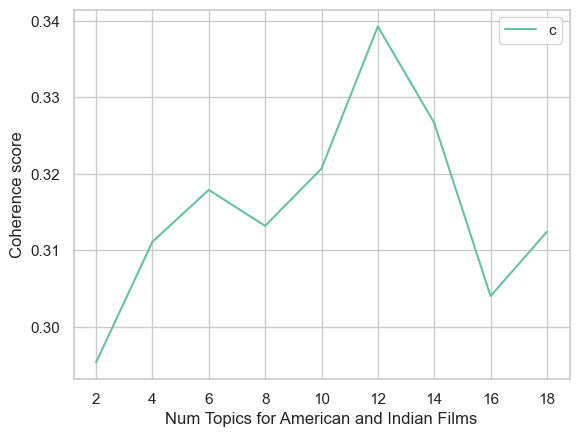

In [85]:
limit=20; start=2; step=2
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics for American and Indian Films")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [86]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2954
Num Topics = 4  has Coherence Value of 0.3111
Num Topics = 6  has Coherence Value of 0.3179
Num Topics = 8  has Coherence Value of 0.3132
Num Topics = 10  has Coherence Value of 0.3207
Num Topics = 12  has Coherence Value of 0.3393
Num Topics = 14  has Coherence Value of 0.3267
Num Topics = 16  has Coherence Value of 0.304
Num Topics = 18  has Coherence Value of 0.3124


The coherence score seems optimal for 12 topics number, we therefore chose this as the optimal LDA model.

In [87]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.005*"power" + 0.005*"people" + 0.005*"use" + 0.004*"world" + 0.004*"city" '
  '+ 0.004*"attempt" + 0.004*"work" + 0.004*"experiment" + 0.004*"hammer" + '
  '0.004*"begin"'),
 (1,
  '0.006*"body" + 0.006*"return" + 0.006*"child" + 0.006*"night" + '
  '0.006*"reveal" + 0.006*"woman" + 0.006*"begin" + 0.006*"home" + '
  '0.005*"room" + 0.005*"see"'),
 (2,
  '0.027*"money" + 0.012*"steal" + 0.012*"dragon" + 0.010*"drug" + '
  '0.007*"stone" + 0.007*"escape" + 0.006*"plan" + 0.006*"prison" + '
  '0.006*"guard" + 0.005*"bank"'),
 (3,
  '0.022*"team" + 0.018*"game" + 0.012*"coach" + 0.008*"player" + 0.006*"town" '
  '+ 0.006*"play" + 0.006*"work" + 0.005*"first" + 0.005*"start" + '
  '0.005*"decide"'),
 (4,
  '0.009*"ship" + 0.009*"alien" + 0.008*"use" + 0.007*"escape" + 0.007*"earth" '
  '+ 0.006*"reveal" + 0.006*"attack" + 0.006*"crew" + 0.006*"discover" + '
  '0.006*"arrive"'),
 (5,
  '0.019*"murder" + 0.012*"police" + 0.008*"gang" + 0.007*"fight" + '
  '0.007*"father" + 0.007*"s

Let us visualize the topics using plDAvis.

In [88]:
%matplotlib inline
data = pyLDAvis.gensim_models.prepare(topic_model = optimal_model, corpus = corpus, dictionary = id2word, sort_topics = False)
pyLDAvis.display(data)

/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

### Interpretation and explanation of the graph

**Topic Bubble:**

- The representation includes topics distribution in the 2-dimensional space (left side panel). These topics are represented in the form of bubbles.

- The larger the bubble, the more frequent is the topic in the documents.

- Since we have a low number of topics (10), we have big non-overlapping bubbles, scattered throughout the chart.

- The distance between the topics is an approximation of the semantic relationship between these latter.

- The topics that share common words will be overlapping in comparison to the non-overlapping topics.

**Horizontal Bar Graph:**

- The bar graph shows the frequency distribution of the words in the documents (in blue color).

- The red area describes the frequency of each word given a topic.

- When selecting a topic (clicking on a topic bubble), the top 30 most relevant term for the topic are shown.

- Hovering over the specific words (in the right panel), the bubbles containing the words grows bigger or smaller if they also have it. The size of the bubble in this scenario describes the weightage of the word on that topic. The higher the weight of the selected word, the larger will be the size of the bubble.

**Relevance Metric:**

- Rank words in topics based on their frequency by varying the relevance metric lambda parameter (top right slide bar), that goes from 0 to 1.

- Decreasing the lambda parameter means increasing the weight of the ratio (Frequency of word given the topic / Overall frequency of the word in the documents). Decreasing the lambda parameters gives words that are more specific to the topic. Important words for the given topic then moves upward.


In [89]:
#Saving the plot to put it in the website
pyLDAvis.save_html(data, 'lda.html')

To prepare our features, let us group each summaries (doc) with its respective percentage of contribution to each topic.

In [90]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus):
    # Initialize the output
    sent_topics_df = pd.DataFrame()

    # Get the number of topic, percentage of contribution and number the document for each summaries (document)
    for i, row in enumerate(ldamodel[corpus]):

        for j, (topic_num, prop_topic) in enumerate(row):
            
            # Here we append topic_num + 1 to number to match each topics accordingly to pLDAvis' graph
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)

    sent_topics_df.columns = ['num_topic', 'topic_perc_contrib','num_document']

    return(sent_topics_df)

sent_topics_df = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Show the documents and their topic contribution
sent_topics_df.head(10)

/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/1334696354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)
/var/folders/87/b39tprrs4vgb71j5qj9sq5hw0000gn/T/ipykernel_38756/1334696354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num+1), round(prop_topic,6), int(i)]), ignore_index=True)


,num_topic,topic_perc_contrib,num_document
0,1.0,0.053508,0.0
1,4.0,0.011648,0.0
2,6.0,0.519854,0.0
3,9.0,0.370530,0.0
4,11.0,0.040369,0.0
5,4.0,0.396300,1.0
6,9.0,0.484895,1.0
7,10.0,0.112445,1.0
8,1.0,0.035613,2.0
9,2.0,0.080376,2.0


We then pivot the precedent data frame to have each columns as a topic.

In [91]:
df_topics = sent_topics_df.copy()

# Pivot the data frame
df_topics = df_topics.pivot(index = 'num_document', columns='num_topic', values='topic_perc_contrib')

# Replace every nan to 0 to interpret this a zero contribution to the topic
df_topics = df_topics.replace(np.nan, 0)

# Finally, join with the summaries to have the wikipedia id and the original text of the summaries
df_topics = df_topics.join(summaries_topic)

df_topics.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,wikipedia_movie_id,summaries
num_document,,,,,,,,,,,,,,
0.0,0.053508,0.000000,0.000000,0.011648,0.0,0.519854,0.000000,0.000000,0.370530,0.000000,0.040369,0.000000,20663735,poovalli induchoodan is sentenced for six yea...
1.0,0.000000,0.000000,0.000000,0.396300,0.0,0.000000,0.000000,0.000000,0.484895,0.112445,0.000000,0.000000,8388648,the film opens with madhav and sreenu playin...
2.0,0.035613,0.080376,0.017345,0.000000,0.0,0.303821,0.000000,0.000000,0.236893,0.164462,0.160703,0.000000,10644072,a villager new to the big city – bhagwaan – t...
3.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.231550,0.000000,0.000000,0.751779,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
4.0,0.099549,0.000000,0.000000,0.000000,0.0,0.000000,0.245026,0.127425,0.293821,0.133414,0.095903,0.000000,19174305,"tahaan lives with his grandfather , mother ha..."


### Description of the topics

Let us identify the topics and label them. To do that, we have observed every topic bubble and identified the keywords that made the most sense to describe the topic.

This enable us to label in a specific manner each topic and not to give a general genre, since we already have that in our features. It was difficult to pinpoint a specific theme since movies' stories can be very broad and unique, so we decided to chose the keywords as the most relevant terms to describe the topics.

We therefore came up with a small description for each topics:

- Topic 1: We chose "experiment, scientist, power, creature" as relevant keywords. This is probably related more to science fiction, with a topic related to experimentations and creating supernatural creatures. It seems to be linked to control and maleficent forces (keywords power, world, use, destroy).

- Topic 2: We chose "body, vampire, child, night" as the relevant keywords. Even though the topic of the family is present (keywords child, home, mother), it seems to be a topic that is in the supernatural register, with a horror part (keywords run, dead, death, attack, body, night). The effect of a glooming revelation seems also depicted by this topic with strong verbs (keywords reveal, discover, appear, realize).

- Topic 3: "money, steal, prisoner, bank, drug" made the most sense to depicts the topic. It seems pretty straightforward that the movies in that topic talks about crimes like stealing, break-ins of banks, drug gangs, involving money in it. The consequences of the crime is also captured by the LDA (keywords prison, guard, prisoner, police, catch). There is also a supernatural component in that topic with the keywords dragon, stone and spell.

- Topic 4: "team, game, coach, player" are the keywords chosen for this topic. It is also straightforward that the topic revolves around the universe of sport, as several sports name are mentioned in the keywords (basketball, football, hockey). The vocabulary of a game is also there (keywords win, lose, score, play, first, start, decide).

- Topic 5: The keywords "ship, alien, earth, attack" are also pretty straightforwards to draw an idea of the topic. It seems more revolved into sci-fi movies, probably involving space adventures (keywords ship, alien, earth), that has also conflict and violence (keywords attack, destroy, death, shoot, fire, use).

- Topic 6: "murder, police, gang, fight, crime". It is also pretty straightforward that the subject revolves around killing (keywords murder, crime, gang, killer, death, shoot). The crime probably involves family in it (keywords father, daughter, wife, brother, family, mother), so it would be more a psychological thriller rather than the topic 3 which involves more of an organization and money in it.

- Topic 7: We chose "agent, shoot, military, bomb" as relevant keywords to depict the topic. This topic seems to be more revolved around the using of military forces (keywords military, soldier, bomb, fire, shoot), in order to maybe to protect an important entity (keywords president, plane, plan, decide, order) from a group or person that wants to harm (keywords group, attempt, bomb) this latter.

- Topic 8: "band, family, show, music, dream" keywords seems describe stories revolved around music and pursuing a dream career in the music domain. The family theme is present (keywords family, mother, home), along with romance (keywords girlfriend, relationship, together). We also have the theme of the desire, probably to succeed in music (keywords dream, want, career, start).

- Topic 9: The "family, father, mother, daughter, wedding" keywords are also very straightforward, and movies that are in this topic revolves around the family, specially around romance and relationship between a man and a woman concretizing into mariage and founding a family together(keywords husband, wife, marry, wedding, pregnant, child). The professional world is also depicted (keywords work, money, business).

- Topic 10 : "home, school, night, parent, party, decide" were the keywords that we chose to describe this topic. Although it is less straightforward than some of the previous topics, it seems to revolves around family (keywords mother, father, parent, home, family), probably with a teenager (keywords school) and involving some conflicts or discussion around that (keywords party, ask, want, talk).

- Topic 11: The keywords "escape, camp, attack, truck" were chosen for that topic. This also depicts the usage of force and violence, so this topic will be found more in the action movies. The vocabulary of protecting something is also present (keywords fight, rescue, town, monster).

- Topic 12 : This last topic's keywords are "movie, woman, play, character, role". This seems to talk about the life in the movie field (keywords role, character, play, movie, lead, story). The character involved seems to be more feminine (keywords woman, girl, wife).

In [92]:
# Label each topics accordingly
df_topics.columns = ['experiment_scientist_power_creature', 'body_vampire_child_night', 'money_steal_prisoner_bank_drug', 'team_game_coach_player', 'ship_alien_earth_attack', 'murder_police_gang_fight_crime', 'agent_shoot_military_bomb', 'band_family_show_music_dream', 'family_father_mother_daughter_wedding', 'home_school_night_parent_party_decide', 'escape_camp_attack_truck', 'movie_woman_play_character_role', 'wikipedia_movie_id', 'summaries']

df_topics.head()

,experiment_scientist_power_creature,body_vampire_child_night,money_steal_prisoner_bank_drug,team_game_coach_player,ship_alien_earth_attack,murder_police_gang_fight_crime,agent_shoot_military_bomb,band_family_show_music_dream,family_father_mother_daughter_wedding,home_school_night_parent_party_decide,escape_camp_attack_truck,movie_woman_play_character_role,wikipedia_movie_id,summaries
num_document,,,,,,,,,,,,,,
0.0,0.053508,0.000000,0.000000,0.011648,0.0,0.519854,0.000000,0.000000,0.370530,0.000000,0.040369,0.000000,20663735,poovalli induchoodan is sentenced for six yea...
1.0,0.000000,0.000000,0.000000,0.396300,0.0,0.000000,0.000000,0.000000,0.484895,0.112445,0.000000,0.000000,8388648,the film opens with madhav and sreenu playin...
2.0,0.035613,0.080376,0.017345,0.000000,0.0,0.303821,0.000000,0.000000,0.236893,0.164462,0.160703,0.000000,10644072,a villager new to the big city – bhagwaan – t...
3.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.231550,0.000000,0.000000,0.751779,4356664,"kishen has a suspicious-minded wife, kaajal ,..."
4.0,0.099549,0.000000,0.000000,0.000000,0.0,0.000000,0.245026,0.127425,0.293821,0.133414,0.095903,0.000000,19174305,"tahaan lives with his grandfather , mother ha..."


# Creation of features

## Actors

In [139]:
df_features_indian_actors = pd.DataFrame({'wikipedia_movie_id':[]})
df_features_american_actors = pd.DataFrame({'wikipedia_movie_id':[]})

In [140]:
# get the ids of the movies from the summaries
df_features_indian_actors['wikipedia_movie_id']=cut_movies_indian['wikipedia_movie_id']
df_features_american_actors['wikipedia_movie_id']=cut_movies_american['wikipedia_movie_id']

In [141]:
# getting the mean age per gender for indian and american films
mean_male_actor_age_india = indian_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_india = indian_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})

mean_male_actor_age_america = american_film_male.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_male_actor_age': np.mean})
mean_female_actor_age_america = american_film_female.groupby('wikipedia_movie_id', as_index=False)['actor_age_at_movie_release'].agg({'mean_female_actor_age': np.mean})


df_features_indian_actors = pd.merge(df_features_indian_actors, mean_male_actor_age_india, on = 'wikipedia_movie_id', how = 'left') 
df_features_indian_actors = pd.merge(df_features_indian_actors, mean_female_actor_age_india, on = 'wikipedia_movie_id', how = 'left')

df_features_american_actors = pd.merge(df_features_american_actors, mean_male_actor_age_america, on = 'wikipedia_movie_id', how = 'left')
df_features_american_actors = pd.merge(df_features_american_actors, mean_female_actor_age_america, on = 'wikipedia_movie_id', how = 'left')


In [142]:
# merging the number of films an actor played in with the rest of the film data
all_american_actors_ext = all_american_actors.merge(all_american_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_american_actors_ext = all_american_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

all_indian_actors_ext = all_indian_actors.merge(all_indian_actors.actor_name.value_counts().reset_index(), left_on = 'actor_name', right_on = 'index', how = 'left')
all_indian_actors_ext = all_indian_actors_ext.groupby('wikipedia_movie_id', as_index=False)['actor_name_y'].agg({'average_number_of_films_actors_played_in': np.mean})

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, all_american_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, all_indian_actors_ext[['wikipedia_movie_id', 'average_number_of_films_actors_played_in']], on = 'wikipedia_movie_id', how = 'left')

In [143]:
# Getting the percent of actress in each movie
def percent_female(x):
    try:
        return x.value_counts().to_dict()['F']/len(x)
    except:
        return 0

percent_female_american_films = all_american_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_american_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)
percent_female_indian_films = all_indian_actors.groupby('wikipedia_movie_id', as_index=False)['actor_gender'].apply(percent_female)
percent_female_indian_films.rename(columns = {'actor_gender':'percent_female_cast'}, inplace = True)

# merging with features
df_features_american_actors = pd.merge(df_features_american_actors, percent_female_american_films, on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, percent_female_indian_films, on = 'wikipedia_movie_id', how = 'left')

# drop the rows with no wikipedia_movie_id
df_features_american_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)
df_features_indian_actors.dropna(subset = ['wikipedia_movie_id'], inplace = True)

## Summaries

### LDA Topic Detection Analysis

In [98]:
topic_features_indian = df_topics.copy()

topic_features_indian = df_topics[df_topics['wikipedia_movie_id'].isin(cut_movies_indian['wikipedia_movie_id'])]

topic_features_indian = topic_features_indian.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_indian.head()

,experiment_scientist_power_creature,body_vampire_child_night,money_steal_prisoner_bank_drug,team_game_coach_player,ship_alien_earth_attack,murder_police_gang_fight_crime,agent_shoot_military_bomb,band_family_show_music_dream,family_father_mother_daughter_wedding,home_school_night_parent_party_decide,escape_camp_attack_truck,movie_woman_play_character_role,wikipedia_movie_id
0,0.053508,0.000000,0.000000,0.011648,0.0,0.519854,0.000000,0.000000,0.370530,0.000000,0.040369,0.000000,20663735
1,0.000000,0.000000,0.000000,0.396300,0.0,0.000000,0.000000,0.000000,0.484895,0.112445,0.000000,0.000000,8388648
2,0.035613,0.080376,0.017345,0.000000,0.0,0.303821,0.000000,0.000000,0.236893,0.164462,0.160703,0.000000,10644072
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.231550,0.000000,0.000000,0.751779,4356664
4,0.099549,0.000000,0.000000,0.000000,0.0,0.000000,0.245026,0.127425,0.293821,0.133414,0.095903,0.000000,19174305


In [99]:
topic_features_american= df_topics.copy()

topic_features_american = df_topics[df_topics['wikipedia_movie_id'].isin(cut_movies_american['wikipedia_movie_id'])]

topic_features_american = topic_features_american.reset_index().drop(columns = ['summaries', 'num_document'])

topic_features_american.head()

,experiment_scientist_power_creature,body_vampire_child_night,money_steal_prisoner_bank_drug,team_game_coach_player,ship_alien_earth_attack,murder_police_gang_fight_crime,agent_shoot_military_bomb,band_family_show_music_dream,family_father_mother_daughter_wedding,home_school_night_parent_party_decide,escape_camp_attack_truck,movie_woman_play_character_role,wikipedia_movie_id
0,0.000000,0.499612,0.012749,0.0,0.041808,0.0,0.000000,0.000000,0.021120,0.422250,0.0,0.000000,1952976
1,0.000000,0.042813,0.000000,0.0,0.000000,0.0,0.000000,0.168803,0.000000,0.763205,0.0,0.022133,24225279
2,0.000000,0.000000,0.329245,0.0,0.000000,0.0,0.000000,0.000000,0.345919,0.317824,0.0,0.000000,15401493
3,0.017313,0.000000,0.101624,0.0,0.000000,0.0,0.024585,0.026617,0.000000,0.742383,0.0,0.086287,1480747
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.917307,0.000000,0.000000,0.0,0.068793,4018288


### Sentiment Anaylsis

In [100]:
print('The mean length of american summaries is {1:.2f} words and for indian summaries it is {0:.2f} words.'.format(
    np.mean([len(ele.split(' ')) for ele in summaries_indian['summaries']]),
    np.mean([len(ele.split(' ')) for ele in summaries_american['summaries']])
))

The mean length of american summaries is 394.88 words and for indian summaries it is 288.94 words.


In [136]:
#can take up to 3min to run

#defining analyzer
analyzer = SentimentIntensityAnalyzer()

#computing sentiments for each summary
indian_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in summaries_indian['summaries']])
american_sentiments = pd.DataFrame([analyzer.polarity_scores(summary) for summary in summaries_american['summaries']])

#adding wikipedia id for future merges
indian_sentiments['wikipedia_movie_id']=summaries_indian['wikipedia_movie_id']
american_sentiments['wikipedia_movie_id']=summaries_american['wikipedia_movie_id']
indian_sentiments.head()

,neg,neu,pos,compound,wikipedia_movie_id
0,0.178,0.704,0.119,-0.9867,20663735
1,0.082,0.757,0.162,0.9920,8388648
2,0.179,0.670,0.152,-0.9960,10644072
3,0.068,0.795,0.137,0.9493,4356664
4,0.065,0.835,0.100,0.8778,19174305


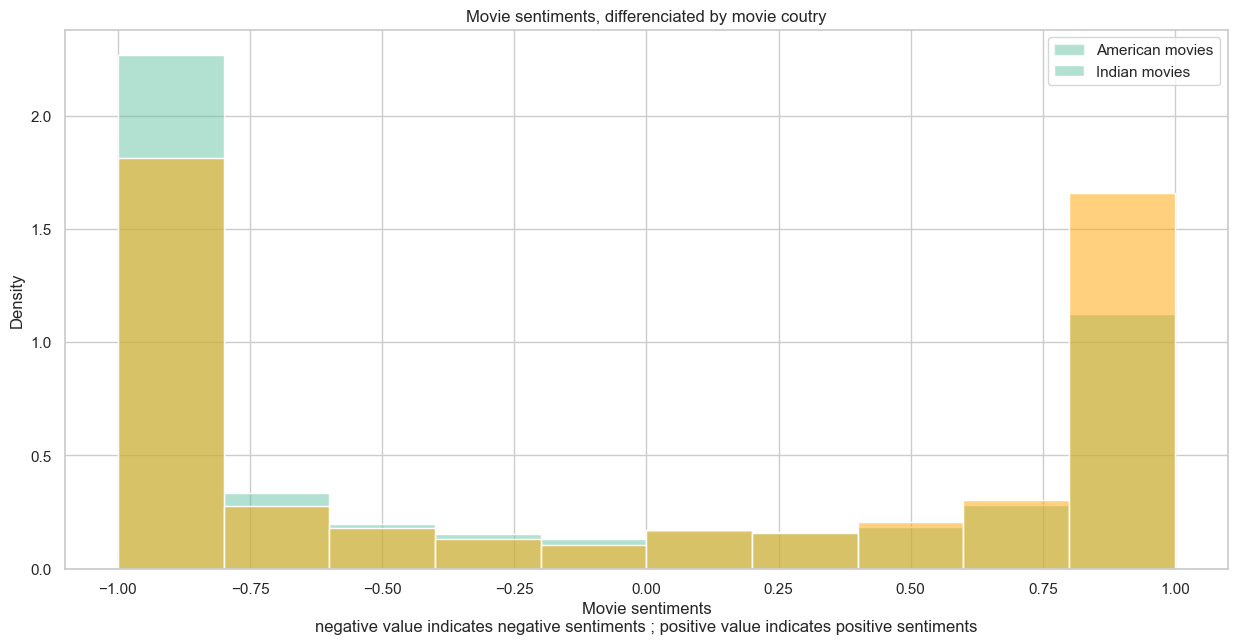

In [102]:
plt.figure(figsize=(15,7))

sns.histplot(american_sentiments['compound'], alpha =.5, stat = 'density', bins = 10)
sns.histplot(indian_sentiments['compound'], alpha=.5, color = 'orange', stat = 'density', bins = 10)
plt.legend(labels=["American movies","Indian movies"])
plt.xlabel('Movie sentiments\nnegative value indicates negative sentiments ; positive value indicates positive sentiments')
plt.title('Movie sentiments, differenciated by movie coutry')
plt.show()

## Movie genres

First, as we can see in the movie genres first analysis, more than a hundred differents genres describe movies. For simplicity's sake, we limit the number of genres by taking a list of the main genres on ImDB. 

Furthermore, some of them are classified in two genres like "romantic drama". We decide here to categorize those movies as "romantic" **and** "drama".

Each movies is described by dummies where for each genre it will either have 1 if the genre is detected or 0 if not. 

In [121]:
movie_genre_imdb =  pd.Series(['action','adventure','animation','biography','comedy','crime','documentary','drama','family',
                              'fantasy','noir','history', 'horror','musical','mystery','romance','sci fi','short Film',
                              'sport','superhero','thriller','war','western'])
#suppress punctuation and words that wont be taken as a genre and that are in high numbers
nope_words = [',', 'film', 'bollywood', 'world', 'cinema']

In [122]:
for char in nope_words:
    genre_indian['movie_genres'] = genre_indian['movie_genres'].str.replace(char, '')
    genre_indian['movie_genres'] = genre_indian['movie_genres'].str.replace('  ', ' ')
    genre_american['movie_genres'] = genre_american['movie_genres'].str.replace(char, '')
    genre_american['movie_genres'] = genre_american['movie_genres'].str.replace('  ', ' ')

In [123]:
#create the dummies variables for each movie for each genres
genre_dummies_indian = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_indian[char] = pd.Series(genre_indian['movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))
    
genre_dummies_american = pd.DataFrame()
for char in movie_genre_imdb:
    genre_dummies_american[char] = pd.Series(genre_american['movie_genres'].apply(lambda x: pd.Series(x).str.contains(char[:3]).any().astype('int')))

In [124]:
#adding the wikipedia ID for merging
genre_dummies_indian['wikipedia_movie_id'] = genre_indian['wikipedia_movie_id']
genre_dummies_american['wikipedia_movie_id'] = genre_american['wikipedia_movie_id']

## Merging the features

In [147]:
df_features_american_actors = pd.merge(df_features_american_actors, american_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')
df_features_indian_actors = pd.merge(df_features_indian_actors, indian_sentiments[['wikipedia_movie_id', 'compound']], on = 'wikipedia_movie_id', how = 'left')

In [149]:
features_indian = pd.merge(genre_dummies_indian, df_features_indian_actors, on= 'wikipedia_movie_id', how = 'right')
features_american = pd.merge(genre_dummies_american, df_features_american_actors, on= 'wikipedia_movie_id', how = 'right')

In [150]:
rating_indian = cut_movies_indian.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]
rating_american = cut_movies_american.dropna(subset = 'averageRating')[['wikipedia_movie_id', 'averageRating']]

In [151]:
features_indian = pd.merge(features_indian, topic_features_indian, on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, topic_features_american, on= 'wikipedia_movie_id', how = 'left')
features_indian = pd.merge(features_indian, rating_indian, on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, rating_american, on= 'wikipedia_movie_id', how = 'left')
features_indian = pd.merge(features_indian, genre_indian[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')
features_american = pd.merge(features_american, genre_american[['wikipedia_movie_id', 'movie_release_date']], on= 'wikipedia_movie_id', how = 'left')

In [153]:
features_indian.dropna(subset='experiment_scientist_power_creature', inplace = True)
features_american.dropna(subset='experiment_scientist_power_creature', inplace = True)
features_indian.iloc[:,0:23] = features_indian.iloc[:,0:23].fillna(0) ; features_indian.iloc[:,24:29] = features_indian.iloc[:,24:29].fillna(features_indian.iloc[:,24:29].mean())
features_american.iloc[:,0:23] = features_american.iloc[:,0:23].fillna(0) ; features_american.iloc[:,24:29] = features_american.iloc[:,24:29].fillna(features_american.iloc[:,24:29].mean())

In [131]:
# to csv
#features_indian.to_csv('features_indian.csv', index = False)
#features_american.to_csv('features_american.csv', index = False)

In [173]:
features_indian = pd.read_csv(data_folder + 'features_indian.csv')
features_american = pd.read_csv(data_folder + 'features_american.csv')
features = pd.concat([features_indian, features_american], axis = 0).reset_index(drop = True)

In [155]:
features_indian_train = features_indian.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()
features_american_train = features_american.drop(['wikipedia_movie_id', 'movie_release_date', 'averageRating'], axis = 1).copy()

american_ratings = features_american[['averageRating', 'movie_release_date']]
indian_ratings = features_indian[['averageRating', 'movie_release_date']]
#standardize the data
features_indian_train.iloc[:,23:] = (features_indian_train.iloc[:,23:] - features_indian_train.iloc[:,23:].mean())/features_indian_train.iloc[:,23:].std()
features_american_train.iloc[:,23:] = (features_american_train.iloc[:,23:] - features_american_train.iloc[:,23:].mean())/features_american_train.iloc[:,23:].std()

# Topics through time

In [156]:
topics_indian = features_indian.iloc[:, 29:41]
topics_american = features_american.iloc[:, 29:41]

topics_indian['country'] = 'indian'
topics_american['country'] = 'american'

topics_indian['dominant_topic'] = topics_indian.iloc[:,:-2].apply(lambda x: np.argmax(x)+1, axis=1)
topics_american['dominant_topic'] = topics_american.iloc[:,:-2].apply(lambda x: np.argmax(x)+1, axis=1)

topics_indian['movie_release_date'] = features_indian['movie_release_date']
topics_american['movie_release_date'] = features_american['movie_release_date']

topics = pd.concat([topics_indian, topics_american], axis=0)

# proportion of topic per year for indian movies
t1 = topics.loc[topics['country'] == 'indian'].groupby('movie_release_date').mean().iloc[:,:-1]
t1['country'] = 'indian'
# proportion of topic per year for american movies
t2 = topics.loc[topics['country'] == 'american'].groupby('movie_release_date').mean().iloc[:,:-1]
t2['country'] = 'american'

t = pd.concat([t1, t2], axis=0).reset_index()
t_tmp = t.melt(id_vars=['country'], value_vars=t.columns[1:-1], var_name='topic', value_name='value')
t_tmp_short = t_tmp.groupby(['topic', 'country']).agg(['mean', 'std']).reset_index()
t_tmp_short.columns = ['topic', 'country', 'mean', 'std']

# add a column with the 95% confidence interval for the mean by bootstrap
t_tmp_short['ci'] = t_tmp_short.apply(lambda x: st.t.interval(0.95, len(t_tmp.loc[(t_tmp['topic'] == x['topic']) & (t_tmp['country'] == x['country'])]) - 1, loc=x['mean'], scale=st.sem(t_tmp.loc[(t_tmp['topic'] == x['topic']) & (t_tmp['country'] == x['country'])]['value'])), axis=1)
t_tmp_short['ci'] = (np.vstack(t_tmp_short['ci'].to_numpy())[:,1] - np.vstack(t_tmp_short['ci'].to_numpy())[:,0])/2

In [157]:
fig = px.bar(data_frame=t_tmp_short, x='topic', y='mean', error_y= 'ci', color='country', barmode='group', category_orders={'topic': ['topic_{}'.format(i) for i in range(0, 10)]})
fig.update_layout(barmode='group')
fig.select_xaxes('category')
fig.show()

py.plot(fig, filename = 'barplot_topics_2', auto_open=False)

'https://plotly.com/~lgburget/82/'

# Grouped genres frequency

In [158]:
#Dropping the compound column
features_american.drop(columns='compound', inplace=True)
features_indian.drop(columns='compound', inplace=True)
features_indian_train.drop(columns='compound', inplace=True)
features_american_train.drop(columns='compound', inplace=True)

In [159]:
#computing the frequency of each genre
genres_indian = pd.DataFrame(features_indian.iloc[:,:23].sum()/features_indian.shape[0], index=features_indian.columns[:23], columns=['frequency']).sort_values('frequency', ascending=False)
genres_american = pd.DataFrame(features_american.iloc[:,:23].sum()/features_american.shape[0], index=features_american.columns[:23], columns=['frequency']).sort_values('frequency', ascending=False)

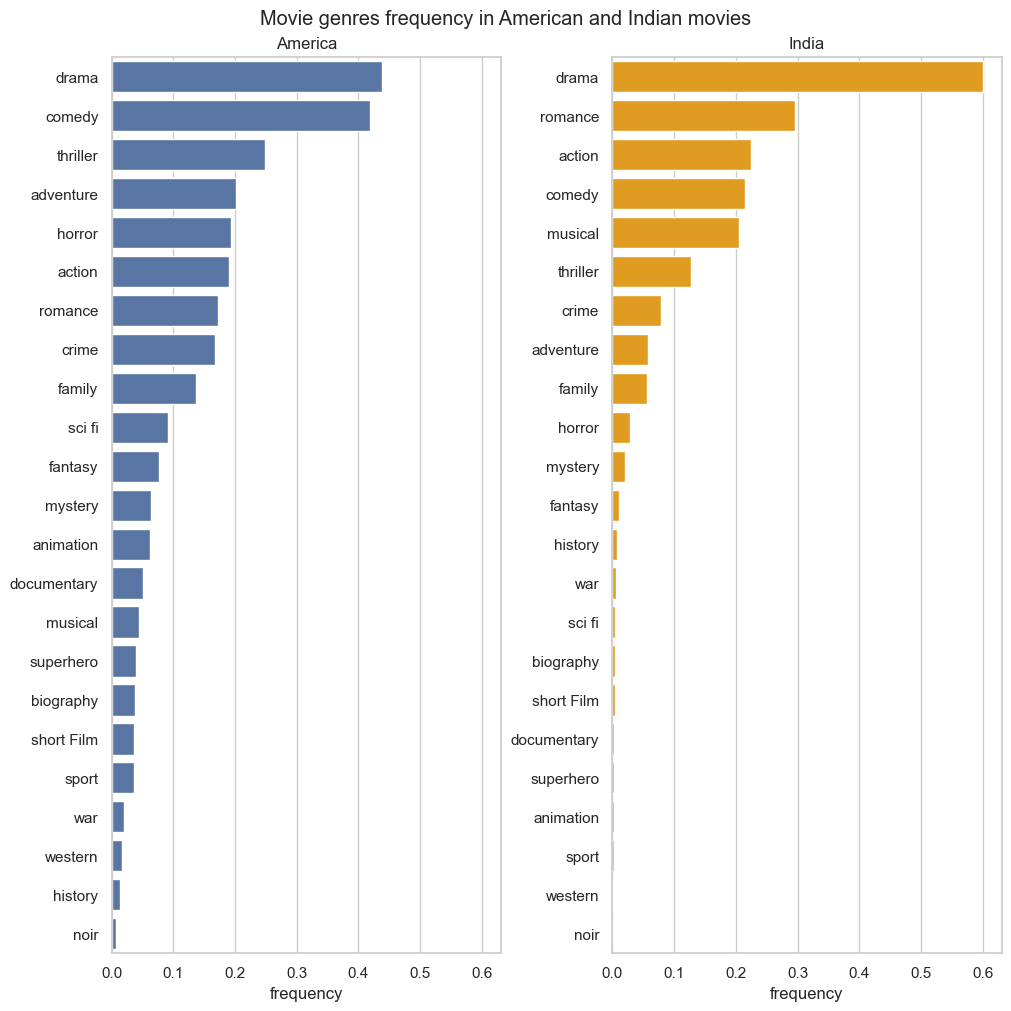

In [160]:
fig, ax = plt.subplots(1,2,figsize=(10, 10),sharex = True, constrained_layout=True)
fig.suptitle('Movie genres frequency in American and Indian movies')
ax[0].set_title('America')
ax[1].set_title('India')

sns.barplot(ax = ax[0],y = genres_american.index, x = genres_american['frequency'], label="American", color="b")
sns.barplot(ax = ax[1], y = genres_indian.index, x = genres_indian['frequency'], label="Indian", color="orange")
plt.show()

# t-distributed Stochastic Neighbor Embedding (t-SNE)

In this section we run t-SNE on standardized values of topics prevalence and mean actor data (mean male/female actor age, average number of film played per actor, percent female actor). Then, we isolate one specific genre and used K-Means on the two t-SNE features to cluster the movies in K cluster. We chose an adequate K by looking at the data and estimating the number of clusters that would make sense. 

On the first plot, you can see all the movies of our dataset on the period 1980-2010 of the genre of interest. 
You can switch between 2 colors: the first one simply shows the country of origin of the movies, the second one shows you to which cluster belongs each movie. 

On the second plot we analyze each cluster.
You can switch between 3 panels: 
- On the first panel, you can visualize the standardized mean prevalence of each topic for each cluster. A positive value indicates that on average in this cluster the topic is more present than the average on our whole dataset. 
- On the second panel, you can visualize if a country is over-represented in a cluster compared to the proportion of movies in our dataset for the studied genre. For this purpose, we simply normalize by dividing each proportion of each cluster by its proportion in the genre. 
- Finally, on the last panel you can observe the means of the different actor data we computed. Those values are not normalized as they are already self explanatory.

In [161]:
# running t-sne on the topics and actor data
tsne = TSNE(n_components=2, random_state=0, learning_rate='auto', init = 'pca')
features_tsne = pd.DataFrame(tsne.fit_transform(pd.concat([features_indian_train.iloc[:,:23], features_american_train.iloc[:,:23]])), columns=['tsne1', 'tsne2'])
features_indian_tsne = features_tsne.iloc[:features_indian_train.shape[0], :].reset_index(drop=True)
features_american_tsne = features_tsne.iloc[features_indian_train.shape[0]:, :].reset_index(drop=True)

/Users/lindadelacombaz/opt/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [162]:
#we use dummies for the genres and non standardized values for actor data...
feats_indian = features_indian.copy().drop(columns=['movie_release_date', 'wikipedia_movie_id' ,'averageRating']).reset_index(drop=True)
feats_american = features_american.copy().drop(columns=['movie_release_date', 'wikipedia_movie_id' ,'averageRating']).reset_index(drop=True)

# ...and z-score for the topics prevalence
feats_indian.iloc[:,27:]=features_indian_train.iloc[:,27:]
feats_american.iloc[:,27:]=features_american_train.iloc[:,27:]

#features = pd.concat([feats_indian, feats_american]).reset_index(drop=True)
colors_country = np.append(np.repeat('orange', feats_indian.shape[0]), np.repeat('blue', feats_american.shape[0]))

In [163]:
genre='comedy'
n=4
colors = []
random.seed(0)

#generating random colors for the clusters
for i in range(n):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))

#running kmeans on the features from tsne
kmeans = KMeans(n_clusters=n, random_state=3).fit(features_tsne[features[genre]==1])

country = np.append(np.repeat(1, sum(feats_indian[genre]==1)) , np.repeat(0,sum(feats_american[genre]==1)))
cols=np.append(feats_indian.columns[23:], ['Indian', 'American'])

#finding movies with the corresponding genre
feats_topics = np.append(feats_indian[feats_indian[genre]==1].iloc[:,23:].values, feats_american[feats_american[genre]==1].iloc[:,23:].values, axis=0)
ratio_country = np.mean(country)

#computing the mean of each feature for each cluster
res = pd.DataFrame(np.zeros((n, len(cols))), columns=cols, dtype=float)
for i in range(n):
    res.iloc[i, :]=np.append(np.mean(feats_topics[kmeans.labels_==i, :], axis=0), [np.mean(country[kmeans.labels_==i]==1)/ratio_country, np.mean(country[kmeans.labels_==i]==0)/(1-ratio_country)])

res['percent_female_cast']*=100

#reshaping the dataframe for the plotly plot
res2 = pd.DataFrame({'cluster':np.array([np.repeat(i, res.shape[1]) for i in range(n)]).flatten().astype(int), 'feature':np.tile(res.columns, n).astype(str), 'value':res.values.flatten().astype(float)})

fig = go.Figure()

#adding the scatter plot
fig.add_scatter(x=features_tsne.loc[features[genre]==1, 'tsne1'], y=features_tsne.loc[features[genre]==1,'tsne2'], mode='markers', marker = dict(color = colors_country[features[genre]==1], size = 5), name='Country')

fig.update_layout(
    width=800,
    height=900,
    autosize=False,
    margin=dict(t=0, b=0, l=0, r=0),
    template="plotly_white",
)

#adding a button to switch between countries and kmeans coloring
fig.update_layout(
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=["marker", dict(color = colors_country[features[genre]==1], size = 5)],
                    label="Country",
                    method="restyle"
                ),
                dict(
                    args=["marker", dict(color=np.array(colors)[kmeans.labels_], size=5)],
                    label="KMeans",
                    method="restyle"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

#adding an annotation
fig.update_layout(
    annotations=[
        dict(text="Color:", showarrow=False,
                             x=-50, y=1.08, yref="paper", align="left")
    ],
    title=dict(text=genre+ ' : t-SNE', x=0.5, y=0.97, xanchor='auto', yanchor='top', font=dict(size=30)),
)

fig.show()

In [164]:
topics = ['experiment_scientist_power_creature', 'body_vampire_child_night', 'money_steal_prisoner_bank_drug', 'team_game_coach_player', 'ship_alien_earth_attack', 'murder_police_gang_fight_crime', 'agent_shoot_military_bomb', 'band_family_show_music_dream', 'family_father_mother_daughter_wedding', 'home_school_night_parent_party_decide', 'escape_camp_attack_truck', 'movie_woman_play_character_role']

fig = go.Figure()

#adding figures related to topics
for i in topics:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i)
#adding figures related to countries
for i in ['Indian', 'American']:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i, visible=False)
#adding features related to actor data
for i in res2['feature'][:4]:
    fig.add_bar(x=res2.loc[res2['feature']==i, 'cluster'], y=res2.loc[res2['feature']==i, 'value'], marker_color=colors, name=i, visible=False)

# creating buttons to interact with the plot
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=list([
                dict(label="Topics",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(True, 12), np.repeat(False, 6)))}]),
                dict(label="Countries",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(False, 12), np.append(np.repeat(True, 2), np.repeat(False, 4))))}]),
                dict(label="Actor data",
                     method="update",
                     args=[{"visible": list(np.append(np.repeat(False, 14), np.repeat(True, 4)))}]),
            ]),
        )
    ],
    barmode='group', title=dict(text=genre+ ' : topic, country and gender representation', x=0.5, y=0.97, xanchor='auto', yanchor='top', font=dict(size=30)))

fig.update_layout(showlegend=False)

fig.show()

In [165]:
clus = 2
clus2 = 3
pvalues_topics = pd.DataFrame(st.ttest_ind(feats_topics[kmeans.labels_==clus, 4:], feats_topics[kmeans.labels_==clus2, 4:]).pvalue, columns = ['pvalue of t-test'], index=topics)

pvalues_topics

,pvalue of t-test
experiment_scientist_power_creature,3.866874e-03
body_vampire_child_night,3.980351e-10
money_steal_prisoner_bank_drug,4.896311e-34
team_game_coach_player,5.361195e-09
ship_alien_earth_attack,3.502979e-29
murder_police_gang_fight_crime,4.501689e-33
agent_shoot_military_bomb,1.457617e-46
band_family_show_music_dream,7.557738e-29
family_father_mother_daughter_wedding,1.641815e-20
home_school_night_parent_party_decide,1.286321e-59


**Explaination of the table:** Here we test the null hypothesis that the 2 cluster have identical average topic prevalence.

In [166]:
for c in range(n):
    chi = st.chisquare([np.sum(country[kmeans.labels_==c]==1), np.sum(country[kmeans.labels_==c]==0)], f_exp=[round(sum(country)/len(country)*sum(kmeans.labels_==c), 0),round(sum(country==0)/len(country)*sum(kmeans.labels_==c), 0)]).pvalue
    print(f'The p-value for the null hypothesis that the distribution of the country in cluster {c} is the same as the distribution of the country in the whole dataset of {genre} is {chi}')

The p-value for the null hypothesis that the distribution of the country in cluster 0 is the same as the distribution of the country in the whole dataset of comedy is 0.01929710808009337
The p-value for the null hypothesis that the distribution of the country in cluster 1 is the same as the distribution of the country in the whole dataset of comedy is 1.3230169505816393e-10
The p-value for the null hypothesis that the distribution of the country in cluster 2 is the same as the distribution of the country in the whole dataset of comedy is 2.420987932479338e-06
The p-value for the null hypothesis that the distribution of the country in cluster 3 is the same as the distribution of the country in the whole dataset of comedy is 0.08922686745995392


We deduce from those statistical tests that clusters 2 and 3 are significantly unbalanced and are more represented by one of the 2 countries. Additionaly, we notice many differences in topics representation that are statistically significant. Hence, we can say that those 2 clusters are probabily separate sub-genres with their own identity.

# Wordclouds

In this section we are interested in finding the words that occur the most often in the Indian and American romantic movies summaries and underlying the differences between the two countries. We use the same pre-processing steps as in the LDA topic detection analysis and then use the wordcloud library to plot the wordclouds.

In [167]:
genre='romance'

# filter indian and american summaries with only romantic films
indian_summaries_genre = summaries_indian.merge(features_indian[['wikipedia_movie_id', genre]], on = 'wikipedia_movie_id')
indian_summaries_genre = indian_summaries_genre[indian_summaries_genre[genre] == 1].drop(columns=genre)

american_summaries_genre = summaries_american.merge(features_american[['wikipedia_movie_id', genre]], on = 'wikipedia_movie_id')
american_summaries_genre = american_summaries_genre[american_summaries_genre[genre] == 1].drop(columns=genre)

In [168]:
# create a list of stopwords and add missing words ; we add the word 'film'
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'film'])
counter = CountVectorizer()

**NOTE:** We add the word 'film' to the stopwords list because it is present in many summaries and often used in sentences like 'The film is about...' and is not relevant to the context of the movie

In [169]:
def make_wordcloud(df, country):
    # Create bigram models for nlp
    words = list(sent_to_words(df['summaries']))
    global bigram 
    bigram = gensim.models.Phrases(words, min_count=15, threshold=100) # higher threshold fewer phrases.
    global bigram_mod 
    bigram_mod= gensim.models.phrases.Phraser(bigram)

    # Apply NLP pipeline : remove stopwords, make bigrams, lemmatize
    words = remove_stopwords(words)
    words = make_bigrams(words)
    words = lemmatization(words, allowed_postags=['NOUN', 'ADJ'])

    # create bag of words matrix
    count_matrix = counter.fit_transform((pd.Series(words, dtype = str)))
    feature_array = np.array(counter.get_feature_names_out())

    # average BOW for each word
    avg_count = np.mean(count_matrix, axis=0)
    w = {feature_array[i]: avg_count[0,i] for i in range(0, count_matrix.shape[1])}

    # generate the mask and color generator for wordcloud
    if (country=='india'):
        mask_ = np.array(Image.open('./img/india.png'))
        mask = np.array(list(map(lambda x: [255, 255, 255, 255] if x < 2 else [0,0,0,255] ,mask_.flatten())))
        mask = mask.reshape(mask_.shape[0], mask_.shape[1], 4)
        coloring = ImageColorGenerator(np.array(Image.open("./img/india_flag.jpg")))
    elif (country=='usa'):
        mask_ = np.array(Image.open('./img/usa.png'))
        mask = np.array(list(map(lambda x: [255, 255, 255, 255] if x == 1 else [0,0,0,255] ,mask_.flatten())))
        mask = mask.reshape(mask_.shape[0], mask_.shape[1], 4)
        coloring = ImageColorGenerator(np.array(Image.open("./img/usa_flag.jpg")))
    else:
        assert 1==0, 'country should be India or USA'
    
    # generate the wordcloud
    wordcloud = WordCloud(color_func = coloring, background_color="white", max_words = 300, width = 1000, height = 800, stopwords=STOPWORDS, mask=mask).generate_from_frequencies(w)
    
    return wordcloud.to_image()
    

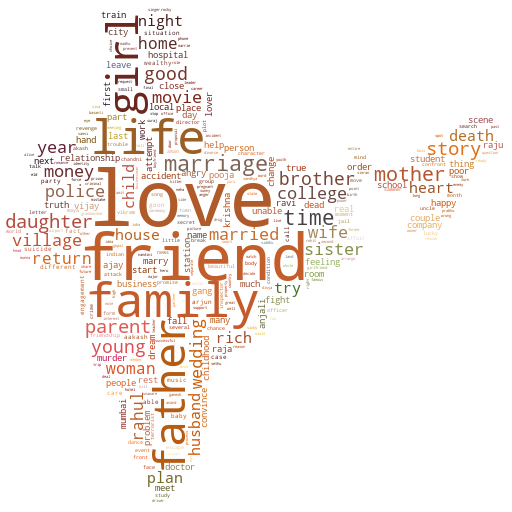

In [171]:
make_wordcloud(indian_summaries_genre, 'india')

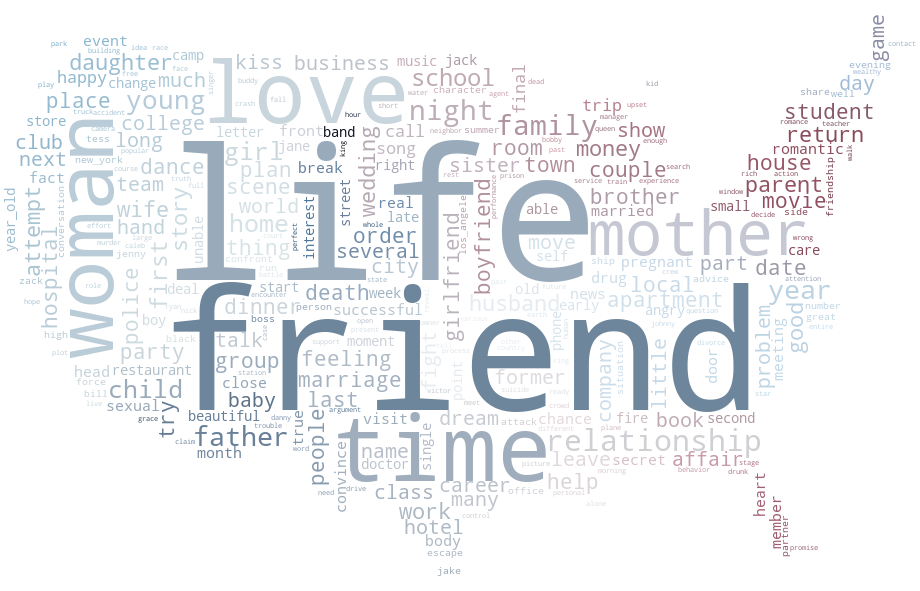

In [172]:
make_wordcloud(american_summaries_genre, 'usa')

**Note**: We notice that the notion of time is very important in American movies whereas it is not the case at all in India. It is also suprising to see that the word woman is more important than the word girl in the US whereas it is the opposite in India. This can maybe be put in perspective with what we observed in the previous section : the mean female actor age in American-dominated cluster of romantic movies is 33 years old whereas it is 27 years old in Indian-dominated clusters (6 years gap!). Moreover, the topics of family and marriage is also much more important in Indian romance than Americans.

# Conclusion

With our study, we can determine that “Bollywood” and “Hollywood” films are surely different. By making a first analysis on different characteristics, we see that they accumulate differences notably on their genres, actors features and runtimes. For the topics talked in movies, they have similarities but some subjects are more present in Indian movies such as family or wedding, while American movies have more stories about school or parties. This analysis shows that there is a cultural difference in American and Indian cinema, even when they are labeled as belonging to the same genre, for example.

We have seen that the genre drama the most common genre in America and India. However, in the last part of our analysis, we see that these type of movies have similar topics keywords for some of the clusters, but also have their differences. Indeed, two clusters stand out for each industry. We have observed that a type of Indian drama is more focused around love, romance and relationship, whereas a type of American drama is more revolved around action with crime and violence (c.f. t-SNE results and country proportion/topic repartition on drama genre, cluster id 0 and 3). Furthermore, it is interesting to see that drama has a lot of subgenres in it and that there is a whole spectrum of different stories within it.

This result supports the idea that the movie industry cultures of two radically different countries are rather difficult to compare and quite complex. Much care needs to be taken when trying to capture the subtle differences that lie between the two cultures.

It is hence reducing to try to label each movies (which is, to some extent a representation of the country's culture : c. f. « Movies and Culture: The Role of Films in Shaping Societal Norms and Values » by Jennifer A. Fritsche, published in the Journal of Social and Political Psychology in 2016.) and have a meaningful, sense-making comparison. It was important here for us to rather observe the differences and to deconstruct our biases towards a different culture and try to take a step back. It was extremely fulfilling to have a critical view of how the Hollywood or American heavily influences western culture (c.f. "The Americanization of European Cinemas: Hollywood's Influence on Local Film Industries" by Mark Jancovich, published in the journal Screen in 2002.).

In addition, we have to keep in mind the bias that we have in the dataset. Indeed, there are many more American films than Indian ones in our data, although the Indian industry is known for its large number of films produced. The films in our data are potentially just the tip of the iceberg. We also may only have the famous films which is not representative of the entire Indian film culture. To support the idea that the Indian film selection in the dataset was shaped by the western view of Indian cinema, we noted the overwhelming presence the (reducing) genre 'world cinema' when labeling the Indian movies.

Finally, we started this analysis by having the assumption that Bollywood, by the essence of its name, was inevitably influenced and shaped by Hollywood. Going through the analysis, learning more and more about Indian movie industry was enlightening and we realized how much these two industries can be considered as entities with their own identities.